In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras.models import load_model
from functools import reduce

import numpy as np
import os
import pickle
import random
import matplotlib.pyplot as plt
import scipy
from scipy.optimize import minimize, fmin_l_bfgs_b
import time

import importlib
import utils.ml_utils as ml_utils

## Init seeds and env variables (makes training deterministic)

In [2]:
ml_utils.init_env()

## Load default train and validation data

In [3]:
default_train, default_validation = ml_utils.load_batched_and_resized_dataset(
    dataset_name='cats_vs_dogs',
    batch_size=1024
)

Training Data Summary
No. of examples: 18610
Class: 0 :::: Count: 9378 :::: Percentage: 50.39226222461043
Class: 1 :::: Count: 9232 :::: Percentage: 49.60773777538957

Validation Data Summary
No. of examples: 4652
Class: 0 :::: Count: 2280 :::: Percentage: 49.011177987962164
Class: 1 :::: Count: 2372 :::: Percentage: 50.988822012037836


## Load previously saved model states and models

In [4]:
batch_sizes = [32, 64, 128, 256]
learning_rates = [0.01, 0.02, 0.04, 0.08, 0.16]

model_state_by_batch_size_and_learning_rate_trial_4 = \
pickle.load(open('pickled_objects/model_state_by_batch_size_and_learning_rate_trial_4.pickle', 'rb'))

initial_model = ml_utils.build_model()
initial_weights = initial_model.get_weights()

models_by_batch_size_and_learning_rate = {}
for batch_size in batch_sizes:
    models_by_batch_size_and_learning_rate[batch_size] = {}
    for learning_rate in learning_rates:
        filepath = 'pickled_objects/batch_size_{}_lr_{}_best_model_trial_4.h5'.format(batch_size, learning_rate)
        models_by_batch_size_and_learning_rate[batch_size][learning_rate] = load_model(filepath)

## Try different batch sizes at varying learning rates

In this notebook, we want to determine the optimal batch size to use, and how important of a decision it is when training a model. To answer these questions, let's try out several batch sizes - 32, 64, 128, and 256. Since we know batch size is sensitive to learning rate (see https://research.fb.com/wp-content/uploads/2017/06/imagenet1kin1h5.pdf) let's also try different learning rates, so we can find the optimal learning rate for each batch size.

In [3]:
model_state_by_batch_size_and_learning_rate_trial_4 = {}
        
for batch_size in batch_sizes:
    # Read training data
    train, validation = ml_utils.load_batched_and_resized_dataset(
        dataset_name='cats_vs_dogs',   
        batch_size=batch_size,
        img_size=128
    )
    model_state_by_batch_size_and_learning_rate_trial_4[batch_size] = {}

    for learning_rate in learning_rates:        
        # Build and train model
        model = ml_utils.build_model(optimizer=keras.optimizers.SGD(learning_rate))
        es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)
        mc = keras.callbacks.ModelCheckpoint(
            'pickled_objects/batch_size_{}_lr_{}_best_model_trial_4.h5'.format(batch_size, learning_rate),
            monitor='val_loss',
            mode='min',
            verbose=1,
            save_best_only=True,
        )
        model_state_by_batch_size_and_learning_rate_trial_4[batch_size][learning_rate] = ml_utils.train_model(
            model,
            train,
            validation,
            epochs=10000,
            extra_callbacks=[es, mc],
        )

Training Data Summary
No. of examples: 18610
Class: 0 :::: Count: 9378 :::: Percentage: 50.39226222461043
Class: 1 :::: Count: 9232 :::: Percentage: 49.60773777538957

Validation Data Summary
No. of examples: 4652
Class: 0 :::: Count: 2280 :::: Percentage: 49.011177987962164
Class: 1 :::: Count: 2372 :::: Percentage: 50.988822012037836
Epoch 1/10000
    582/Unknown - 27s 46ms/step - loss: 0.6926 - accuracy: 0.5135- 27s 46ms/step - loss: 0.6926 - accuracy: 0.513
Epoch 00001: val_loss improved from inf to 0.69189, saving model to pickled_objects/batch_size_32_lr_0.01_best_weights_trial_4.h5
582/582 [==============================] - 33s 57ms/step - loss: 0.6926 - accuracy: 0.5135 - val_loss: 0.6919 - val_accuracy: 0.4963
Epoch 2/10000
581/582 [============================>.] - ETA: 0s - loss: 0.6869 - accuracy: 0.5650
Epoch 00002: val_loss improved from 0.69189 to 0.69019, saving model to pickled_objects/batch_size_32_lr_0.01_best_weights_trial_4.h5
582/582 [=============================

In [6]:
ml_utils.save_model_state(model_state_by_batch_size_and_learning_rate_trial_4, 'model_state_by_batch_size_and_learning_rate_trial_4')

Let's take a look at the loss curves for the different batch sizes at learning rate 0.01.

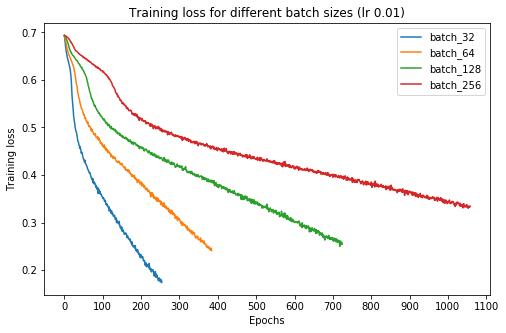

In [156]:
# Plot training losses for batch sizes, at learning rate 0.01
plt.figure(figsize=(8,5))
for batch_size in batch_sizes:
    history = model_state_by_batch_size_and_learning_rate_trial_4[batch_size][0.01].history
    plt.plot(history['loss'], label='batch_{}'.format(batch_size))
plt.xlabel('Epochs')
plt.xticks(range(0, 1200, 100))
plt.ylabel('Training loss')
plt.title('Training loss for different batch sizes (lr 0.01)')
plt.legend()
plt.savefig('graphs/training_loss_batch_size_variable_lr_001')

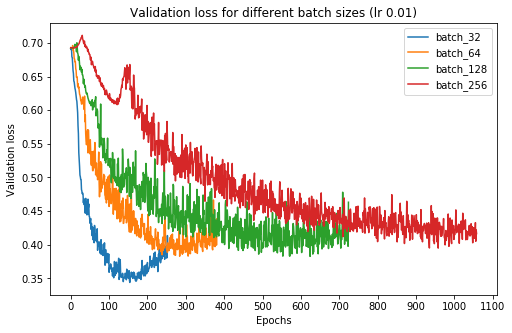

In [155]:
# Plot validation losses for batch sizes, at learning rate 0.01
plt.figure(figsize=(8,5))
for batch_size in batch_sizes:
    history = model_state_by_batch_size_and_learning_rate_trial_4[batch_size][0.01].history
    plt.plot(history['val_loss'], label='batch_{}'.format(batch_size))
plt.xlabel('Epochs')
plt.xticks(range(0, 1200, 100))
plt.ylabel('Validation loss')
plt.title('Validation loss for different batch sizes (lr 0.01)')
plt.legend()
plt.savefig('graphs/validation_loss_batch_size_variable_lr_001')

In [39]:
for batch_size in batch_sizes:
    print("Batch size: {}".format(batch_size))
    history = model_state_by_batch_size_and_learning_rate_trial_4[batch_size][0.01].history
    print("\tTrain loss: {}".format(np.min(history['loss'])))
    print("\tValidation loss: {}".format(np.min(history['val_loss'])))

Batch size: 32
	Train loss: 0.17416517792819072
	Validation loss: 0.3438840186963343
Batch size: 64
	Train loss: 0.24137994115516614
	Validation loss: 0.3829472124168318
Batch size: 128
	Train loss: 0.25001922567674767
	Validation loss: 0.3826464168928765
Batch size: 256
	Train loss: 0.3301195298453161
	Validation loss: 0.3949607736185977


In [173]:
mean_times = []
for batch_size in batch_sizes:
    times = model_state_by_batch_size_and_learning_rate_trial_4[batch_size][0.01].times
    mean_times.append(np.mean(times))
    print("Batch size: {}, mean time per epoch: {}".format(batch_size, np.mean(times)))

Batch size: 32, mean time per epoch: 12.37707226603639
Batch size: 64, mean time per epoch: 9.879916630782091
Batch size: 128, mean time per epoch: 8.346154839088177
Batch size: 256, mean time per epoch: 7.7022849018558


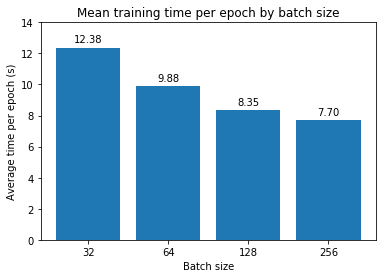

<Figure size 432x288 with 0 Axes>

In [174]:
rects = plt.bar(x=range(len(batch_sizes)), height=mean_times, tick_label=batch_sizes)
autolabel(rects)
plt.xlabel('Batch size')
plt.ylabel('Average time per epoch (s)')
plt.ylim(0, 14)
plt.title('Mean training time per epoch by batch size')
plt.show()
plt.savefig('graphs/mean_epoch_training_time_by_batch_size')

We see that the larger batches converge more slowly, and that they achieve worse validation loss.

## Hypothesis 1: LB (large-batch) minimizers are closer to initial weights

In [55]:
# Define helper method to label bars with values
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        plt.annotate('{:.2f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

In [56]:
flattened_initial_weights = np.concatenate([w.flatten() for w in initial_weights])
distances = []
for batch_size in batch_sizes:
    model = models_by_batch_size_and_learning_rate[batch_size][0.01]
    flattened_weights = np.concatenate([w.flatten() for w in model.get_weights()])
    distance = np.linalg.norm(flattened_weights - flattened_initial_weights)
    distances.append(distance)
    print("Batch size: {}, distance: {}".format(batch_size, distance))

Batch size: 32, distance: 12.450722694396973
Batch size: 64, distance: 11.299184799194336
Batch size: 128, distance: 11.878301620483398
Batch size: 256, distance: 9.444491386413574


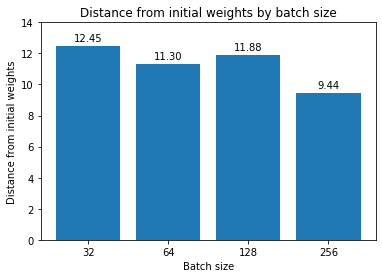

<Figure size 432x288 with 0 Axes>

In [60]:
# Plot distances
rects = plt.bar(x=range(len(batch_sizes)), height=distances, tick_label=batch_sizes)
autolabel(rects)
plt.xlabel('Batch size')
plt.ylim(0, 14)
plt.ylabel('Distance from initial weights')
plt.title('Distance from initial weights by batch size')
plt.show()
plt.savefig('graphs/distance_from_initial_weights_by_batch_size')

## Hypothesis 2: LB minimizers are sharper

In [182]:
# Interpolate between batch size 32 and batch size 256 minimizers
batch_32_weights = models_by_batch_size_and_learning_rate[32][0.01].get_weights()
batch_256_weights = models_by_batch_size_and_learning_rate[256][0.01].get_weights()

alpha_values = np.linspace(-1, 2, 31)
print(alpha_values)
training_losses = []
validation_losses = []

for alpha in alpha_values:
    print("\nTesting alpha: ", alpha)
    model = ml_utils.build_model()
    target_weights = [batch_256_weights[i]*alpha + batch_32_weights[i]*(1-alpha) for i in range(len(batch_32_weights))]
    model.set_weights(target_weights)
    training_loss, training_accuracy = model.evaluate(default_train)
    validation_loss, validation_accuracy = model.evaluate(default_validation)
    training_losses.append(training_loss)
    validation_losses.append(validation_loss)

[-1.  -0.9 -0.8 -0.7 -0.6 -0.5 -0.4 -0.3 -0.2 -0.1  0.   0.1  0.2  0.3
  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3  1.4  1.5  1.6  1.7
  1.8  1.9  2. ]

Testing alpha:  -1.0
      5/Unknown - 1s 143ms/step - loss: 4.6728 - accuracy: 0.5310
Testing alpha:  -0.9
      5/Unknown - 1s 144ms/step - loss: 3.2705 - accuracy: 0.5529
Testing alpha:  -0.8
      5/Unknown - 1s 149ms/step - loss: 2.2388 - accuracy: 0.5791
Testing alpha:  -0.7
      5/Unknown - 1s 142ms/step - loss: 1.5146 - accuracy: 0.6212
Testing alpha:  -0.6
      5/Unknown - 1s 146ms/step - loss: 1.0300 - accuracy: 0.6791
Testing alpha:  -0.5
      5/Unknown - 1s 145ms/step - loss: 0.7202 - accuracy: 0.7337
Testing alpha:  -0.3999999999999999
      5/Unknown - 1s 146ms/step - loss: 0.5358 - accuracy: 0.7756
Testing alpha:  -0.29999999999999993
      5/Unknown - 1s 154ms/step - loss: 0.4295 - accuracy: 0.8130
Testing alpha:  -0.19999999999999996
      5/Unknown - 1s 147ms/step - loss: 0.3719 - accuracy: 0.8317
Testing al

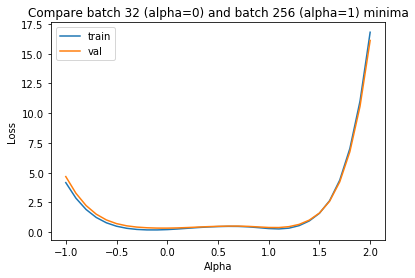

<Figure size 432x288 with 0 Axes>

In [183]:
# Plot interpolation
plt.plot(alpha_values, training_losses, label='train')
plt.plot(alpha_values, validation_losses, label='val')
plt.title("Compare batch 32 (alpha=0) and batch 256 (alpha=1) minima")
plt.xlabel("Alpha")
plt.ylabel("Loss")
plt.legend()
plt.show()
plt.savefig('graphs/batch_size_alpha_trial_4')

     19/Unknown - 3s 140ms/step - loss: 0.2337 - accuracy: 0.9037
Sharpness for batch size 32 at learning rate 0.01: 1.1427959690499176
     19/Unknown - 3s 141ms/step - loss: 1.0464 - accuracy: 0.6578
Sharpness for batch size 64 at learning rate 0.01: 63.23662089553028
     19/Unknown - 3s 141ms/step - loss: 1.0906 - accuracy: 0.6538
Sharpness for batch size 128 at learning rate 0.01: 68.492401585222
     19/Unknown - 3s 138ms/step - loss: 1.5686 - accuracy: 0.5400
Sharpness for batch size 256 at learning rate 0.01: 96.40660438666379


Text(0.5, 1.0, 'Sharpness score by batch size')

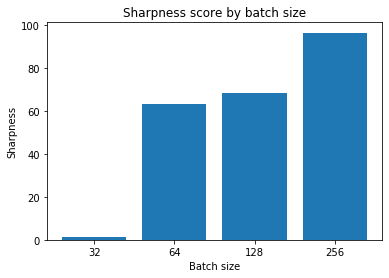

In [50]:
# Get sharpness for each batch size (same lr)
sharpnesses = []
for batch_size in batch_sizes:
    model = models_by_batch_size_and_learning_rate[batch_size][0.01]
    sharpness = ml_utils.get_sharpness(model, default_train, 1e-3)
    sharpnesses.append(sharpness)
    print("\nSharpness for batch size {} at learning rate {}: {}".format(batch_size, 0.01, sharpness))

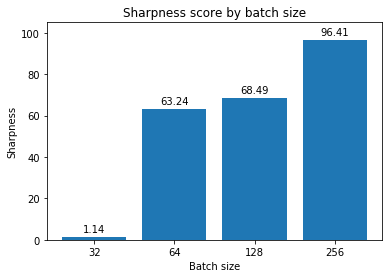

<Figure size 432x288 with 0 Axes>

In [62]:
# Plot sharpnesses
rects = plt.bar(x=range(len(batch_sizes)), height=sharpnesses, tick_label=batch_sizes)
autolabel(rects)
plt.ylim(0, 105)
plt.xlabel('Batch size')
plt.ylabel('Sharpness')
plt.title('Sharpness score by batch size')
plt.show()
plt.savefig('graphs/sharpness_by_batch_size')


 x: -1.0, y: -1.0
     19/Unknown - 3s 148ms/step - loss: 2.3399 - accuracy: 0.5185
 x: -0.5, y: -1.0
     19/Unknown - 3s 140ms/step - loss: 3.3659 - accuracy: 0.5040
 x: 0.0, y: -1.0
     19/Unknown - 3s 136ms/step - loss: 2.3225 - accuracy: 0.5123
 x: 0.5, y: -1.0
     19/Unknown - 3s 138ms/step - loss: 1.4707 - accuracy: 0.5694
 x: 1.0, y: -1.0
     19/Unknown - 3s 141ms/step - loss: 7.0811 - accuracy: 0.5197
 x: -1.0, y: -0.5
     19/Unknown - 3s 143ms/step - loss: 1.5422 - accuracy: 0.5323
 x: -0.5, y: -0.5
     19/Unknown - 3s 140ms/step - loss: 1.1374 - accuracy: 0.5017
 x: 0.0, y: -0.5
     19/Unknown - 3s 139ms/step - loss: 0.9075 - accuracy: 0.5717
 x: 0.5, y: -0.5
     19/Unknown - 3s 137ms/step - loss: 0.6833 - accuracy: 0.6574
 x: 1.0, y: -0.5
     19/Unknown - 3s 136ms/step - loss: 1.5331 - accuracy: 0.5872
 x: -1.0, y: 0.0
     19/Unknown - 3s 137ms/step - loss: 0.9033 - accuracy: 0.5860
 x: -0.5, y: 0.0
     19/Unknown - 3s 140ms/step - loss: 0.7264 - accuracy: 0.5997

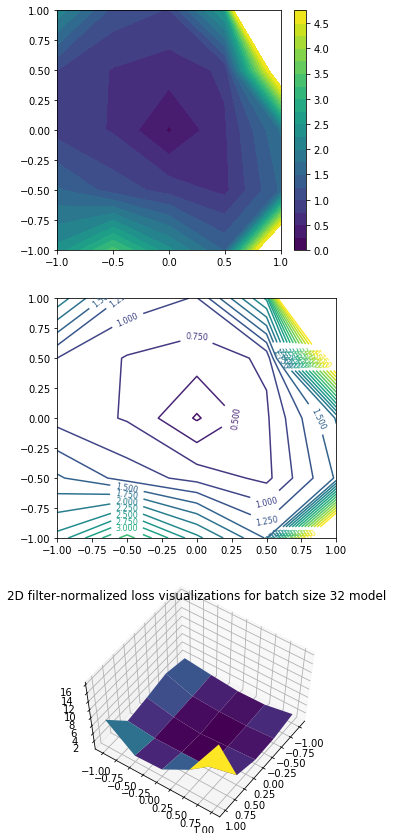

<Figure size 432x288 with 0 Axes>

In [15]:
model = models_by_batch_size_and_learning_rate[32][0.01]
X, Y, Z = ml_utils.plot_loss_visualization_2d(
    model,
    default_train,
    mode='all',
    title='2D filter-normalized loss visualizations for batch size 32 model',
    output_filename='filter_normalized_loss_2d_for_batch_32',
)


 x: -1.0, y: -1.0
     19/Unknown - 3s 146ms/step - loss: 4.8660 - accuracy: 0.5172
 x: -0.5, y: -1.0
     19/Unknown - 3s 143ms/step - loss: 2.8627 - accuracy: 0.5078
 x: 0.0, y: -1.0
     19/Unknown - 3s 140ms/step - loss: 1.7843 - accuracy: 0.5032
 x: 0.5, y: -1.0
     19/Unknown - 3s 139ms/step - loss: 1.2709 - accuracy: 0.5055
 x: 1.0, y: -1.0
     19/Unknown - 3s 140ms/step - loss: 1.5195 - accuracy: 0.5254
 x: -1.0, y: -0.5
     19/Unknown - 3s 141ms/step - loss: 0.9217 - accuracy: 0.6240
 x: -0.5, y: -0.5
     19/Unknown - 3s 144ms/step - loss: 0.7043 - accuracy: 0.6347
 x: 0.0, y: -0.5
     19/Unknown - 3s 141ms/step - loss: 0.7515 - accuracy: 0.5393
 x: 0.5, y: -0.5
     19/Unknown - 3s 143ms/step - loss: 0.7298 - accuracy: 0.5373
 x: 1.0, y: -0.5
     19/Unknown - 3s 142ms/step - loss: 0.8765 - accuracy: 0.5565
 x: -1.0, y: 0.0
     19/Unknown - 3s 145ms/step - loss: 1.3511 - accuracy: 0.5315
 x: -0.5, y: 0.0
     19/Unknown - 3s 143ms/step - loss: 0.5102 - accuracy: 0.7478

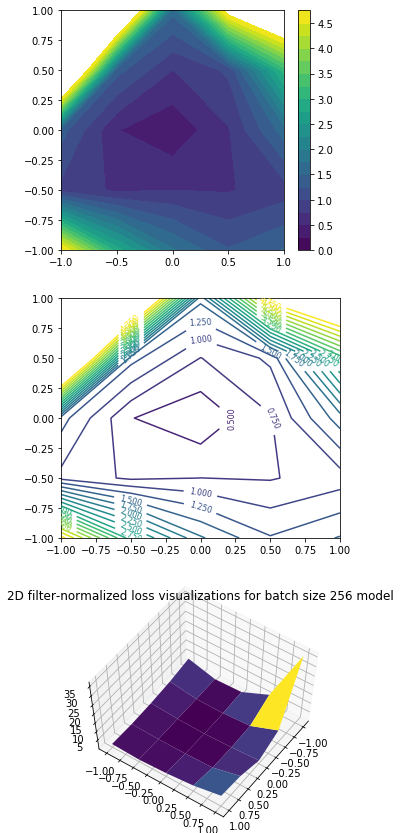

<Figure size 432x288 with 0 Axes>

In [12]:
model = models_by_batch_size_and_learning_rate[256][0.01]
X, Y, Z = ml_utils.plot_loss_visualization_2d(
    model,
    default_train,
    mode='all',
    title='2D filter-normalized loss visualizations for batch size 256 model',
    output_filename='filter_normalized_loss_2d_for_batch_256',
)

## Why do large batch sizes converge more slowly?

As we can see above, given the same learning rate, the larger batch size converges more slowly. Why is this the case? Maybe larger batch sizes make smaller steps. This would be in line with the observation that they find solutions closer to the initial weights.

To evaluate this hypothesis, let's measure the distance traversed per epoch and per batch.

In [63]:
class WeightHistory(keras.callbacks.Callback):
    def __init__(self, store_batch_weights=False):
        self.weights_per_epoch = []
        self.store_batch_weights = store_batch_weights
        if self.store_batch_weights:
            self.weights_per_batch = []
    
    def on_train_begin(self, logs={}):
        self.weights_per_epoch.append(self.model.get_weights())
        if self.store_batch_weights:
            self.weights_per_batch.append(self.model.get_weights())

    def on_batch_end(self, batch, logs={}):
        if self.store_batch_weights:
            self.weights_per_batch.append(self.model.get_weights())
        
    def on_epoch_end(self, epoch, logs={}):
        self.weights_per_epoch.append(self.model.get_weights())


In [73]:
batch_sizes_trial_3 = [32, 256]
model_state_by_batch_size_trial_3 = {}
weight_history_by_batch_size_trial_3 = {}

for batch_size in batch_sizes_trial_3:
    # Read training data
    train, validation = ml_utils.load_batched_and_resized_dataset(
        dataset_name='cats_vs_dogs',   
        batch_size=batch_size,
        img_size=128
    )

    # Build and train model
    model = ml_utils.build_model(optimizer=keras.optimizers.SGD(0.01))
    wh = WeightHistory()
    model_state_by_batch_size_trial_3[batch_size] = ml_utils.train_model(
        model,
        train,
        validation,
        epochs=50,
        extra_callbacks=[wh],
    )
    weight_history_by_batch_size_trial_3[batch_size] = wh

Training Data Summary
No. of examples: 18610
Class: 0 :::: Count: 9378 :::: Percentage: 50.39226222461043
Class: 1 :::: Count: 9232 :::: Percentage: 49.60773777538957

Validation Data Summary
No. of examples: 4652
Class: 0 :::: Count: 2280 :::: Percentage: 49.011177987962164
Class: 1 :::: Count: 2372 :::: Percentage: 50.988822012037836
Epoch 1/50
582/582 [==============================] - 33s 57ms/step - loss: 0.6926 - accuracy: 0.5104 - val_loss: 0.6918 - val_accuracy: 0.4983
Epoch 2/50
582/582 [==============================] - 12s 21ms/step - loss: 0.6869 - accuracy: 0.5651 - val_loss: 0.6901 - val_accuracy: 0.5067
Epoch 3/50
582/582 [==============================] - 12s 21ms/step - loss: 0.6790 - accuracy: 0.5786 - val_loss: 0.6915 - val_accuracy: 0.5125
Epoch 4/50
582/582 [==============================] - 12s 21ms/step - loss: 0.6722 - accuracy: 0.5868 - val_loss: 0.6787 - val_accuracy: 0.5679
Epoch 5/50
582/582 [==============================] - 12s 21ms/step - loss: 0.6661 - a

Epoch 3/50
73/73 [==============================] - 8s 104ms/step - loss: 0.6930 - accuracy: 0.5078 - val_loss: 0.6928 - val_accuracy: 0.5034
Epoch 4/50
73/73 [==============================] - 8s 103ms/step - loss: 0.6923 - accuracy: 0.5211 - val_loss: 0.6928 - val_accuracy: 0.4936
Epoch 5/50
73/73 [==============================] - 8s 104ms/step - loss: 0.6921 - accuracy: 0.5211 - val_loss: 0.6928 - val_accuracy: 0.4916
Epoch 6/50
73/73 [==============================] - 8s 105ms/step - loss: 0.6913 - accuracy: 0.5292 - val_loss: 0.6929 - val_accuracy: 0.4914
Epoch 7/50
73/73 [==============================] - 8s 105ms/step - loss: 0.6907 - accuracy: 0.5383 - val_loss: 0.6929 - val_accuracy: 0.4918
Epoch 8/50
73/73 [==============================] - 8s 105ms/step - loss: 0.6902 - accuracy: 0.5490 - val_loss: 0.6927 - val_accuracy: 0.4914
Epoch 9/50
73/73 [==============================] - 8s 105ms/step - loss: 0.6894 - accuracy: 0.5530 - val_loss: 0.6926 - val_accuracy: 0.4914
Epoch 

In [74]:
ml_utils.save_model_state(model_state_by_batch_size_trial_3, 'model_state_by_batch_size_trial_3')
# Unfortunately the weight history is not picklable due to an RLock object
# ml_utils.save_model_state(weight_history_by_batch_size_trial_3, 'weight_history_by_batch_size_trial_3')

In [75]:
# For the last layer, compute the distance between between epoch weights and epoch+1 weights
epoch_update_magnitudes_by_batch_size = {}
for batch_size in batch_sizes_trial_3:
    epoch_update_magnitudes_by_batch_size[batch_size] = []
    weights_per_epoch = weight_history_by_batch_size_trial_3[batch_size].weights_per_epoch
    for i in range(len(weights_per_epoch)-1):
        curr_epoch_weights = np.concatenate([w.flatten() for w in weights_per_epoch[i]])
        next_epoch_weights = np.concatenate([w.flatten() for w in weights_per_epoch[i+1]])
        epoch_update_magnitudes_by_batch_size[batch_size].append(np.linalg.norm(next_epoch_weights - curr_epoch_weights))

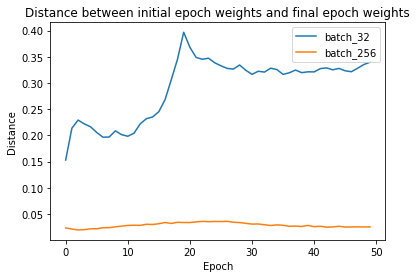

<Figure size 432x288 with 0 Axes>

In [79]:
plt.figure()
plt.plot(epoch_update_magnitudes_by_batch_size[32], label='batch_32')
plt.plot(epoch_update_magnitudes_by_batch_size[256], label='batch_256')
plt.xlabel('Epoch')
plt.ylabel('Distance')
plt.legend()
plt.title('Distance between initial epoch weights and final epoch weights')
plt.show()
plt.savefig('graphs/distance_between_initial_epoch_weights_and_final_epoch_weights')

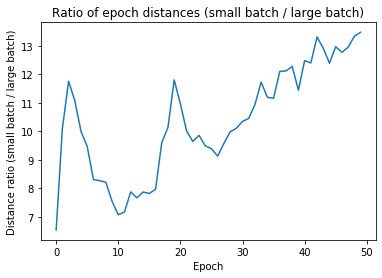

<Figure size 432x288 with 0 Axes>

In [80]:
ratios = [s/l for s, l in zip(epoch_update_magnitudes_by_batch_size[32], epoch_update_magnitudes_by_batch_size[256])]
plt.figure()
plt.plot(ratios)
plt.xlabel('Epoch')
plt.ylabel('Distance ratio (small batch / large batch)')
plt.title('Ratio of epoch distances (small batch / large batch)')
plt.show()
plt.savefig('graphs/epoch_distance_ratios')

The plot above shows that the larger batch sizes do indeed traverse less distance per epoch.

But why does it traverse less distance per epoch? Is it because we have fewer updates with a large batch size? Or is it because each batch update traverses less distance? Or both?

In [83]:
batch_sizes_trial_3 = [32, 256]
batch_weight_history_by_batch_size_trial_3 = {}

for batch_size in batch_sizes_trial_3:
    # Read training data
    train, validation = ml_utils.load_batched_and_resized_dataset(
        dataset_name='cats_vs_dogs',   
        batch_size=batch_size,
        img_size=128
    )

    # Build and train model
    model = ml_utils.build_model(optimizer=keras.optimizers.SGD(0.01))
    wh = WeightHistory(store_batch_weights=True)
    ml_utils.train_model(
        model,
        train,
        validation,
        epochs=1,
        extra_callbacks=[wh],
    )
    batch_weight_history_by_batch_size_trial_3[batch_size] = wh

Training Data Summary
No. of examples: 18610
Class: 0 :::: Count: 9378 :::: Percentage: 50.39226222461043
Class: 1 :::: Count: 9232 :::: Percentage: 49.60773777538957

Validation Data Summary
No. of examples: 4652
Class: 0 :::: Count: 2280 :::: Percentage: 49.011177987962164
Class: 1 :::: Count: 2372 :::: Percentage: 50.988822012037836
582/582 [==============================] - 37s 64ms/step - loss: 0.6926 - accuracy: 0.5104 - val_loss: 0.6918 - val_accuracy: 0.4983
Training Data Summary
No. of examples: 18610
Class: 0 :::: Count: 9378 :::: Percentage: 50.39226222461043
Class: 1 :::: Count: 9232 :::: Percentage: 49.60773777538957

Validation Data Summary
No. of examples: 4652
Class: 0 :::: Count: 2280 :::: Percentage: 49.011177987962164
Class: 1 :::: Count: 2372 :::: Percentage: 50.988822012037836
73/73 [==============================] - 30s 412ms/step - loss: 0.6941 - accuracy: 0.4980 - val_loss: 0.6931 - val_accuracy: 0.5163


In [84]:
# For the last layer, compute the distance between between epoch weights and epoch+1 weights
batch_update_magnitudes_by_batch_size = {}
for batch_size in batch_sizes_trial_3:
    batch_update_magnitudes_by_batch_size[batch_size] = []
    weights_per_batch = batch_weight_history_by_batch_size_trial_3[batch_size].weights_per_batch
    for i in range(len(weights_per_batch)-1):
        curr_batch_weights = np.concatenate([w.flatten() for w in weights_per_batch[i]])
        next_batch_weights = np.concatenate([w.flatten() for w in weights_per_batch[i+1]])
        batch_update_magnitudes_by_batch_size[batch_size].append(np.linalg.norm(next_batch_weights - curr_batch_weights))

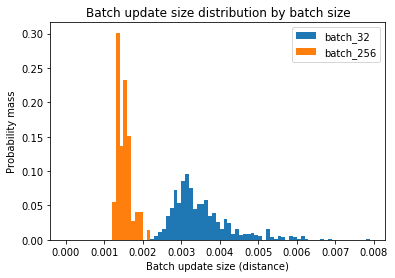

<Figure size 432x288 with 0 Axes>

In [94]:
batch_32_weights = np.ones_like(batch_update_magnitudes_by_batch_size[32]) / len(batch_update_magnitudes_by_batch_size[32])
batch_256_weights = np.ones_like(batch_update_magnitudes_by_batch_size[256]) / len(batch_update_magnitudes_by_batch_size[256])

plt.hist(
    batch_update_magnitudes_by_batch_size[32],
    bins=np.arange(0, 8e-3, 1e-4),
    weights=batch_32_weights,
    label='batch_32'
)
plt.hist(
    batch_update_magnitudes_by_batch_size[256],
    bins=np.arange(0, 8e-3, 1e-4),
    weights=batch_256_weights,
    label='batch_256'
)
plt.ylabel('Probability mass')
plt.xlabel('Batch update size (distance)')
plt.title('Batch update size distribution by batch size')
plt.legend()
plt.show()
plt.savefig('graphs/batch_update_size_distribution')

In [95]:
print("Mean batch update norm for batch size 32: ", np.mean(batch_update_magnitudes_by_batch_size[32]))
print("Mean batch update norm for batch size 256: ", np.mean(batch_update_magnitudes_by_batch_size[256]))

Mean batch update norm for batch size 32:  0.0035173532
Mean batch update norm for batch size 256:  0.0015158369


In [96]:
print("Median batch update norm for batch size 32: ", np.median(batch_update_magnitudes_by_batch_size[32]))
print("Median batch update norm for batch size 256: ", np.median(batch_update_magnitudes_by_batch_size[256]))

Median batch update norm for batch size 32:  0.0033002691
Median batch update norm for batch size 256:  0.0015095416


We can see that each batch update traverses less distance.

Now we know why batch size 256 converges so much more slowly: not only is it making fewer updates, but each update is also smaller.

## Why is each update smaller?

In [98]:
def get_gradient(model, data):
    batch_gradients = []
    for x, y in data:
        with tf.GradientTape() as tape:
            preds = model(x)
            bce = tf.keras.losses.BinaryCrossentropy()
            loss = bce(y, preds)

        gradients = [g.numpy() for g in tape.gradient(loss, model.trainable_variables)]
        flattened_gradients = np.concatenate([g.flatten() for g in gradients])
        batch_gradients.append(flattened_gradients)
    return np.sum(batch_gradients, axis=0)

In [100]:
# Sum of all updates on 1024 examples when batch size is 1
batch_32_model = models_by_batch_size_and_learning_rate[32][0.01]
small_batch_update_size = np.linalg.norm(get_gradient(batch_32_model, default_train.unbatch().batch(1).take(64)))
print("Batch size 1 -> update size ", np.linalg.norm(small_batch_update_size))

Batch size 1 -> update size  68.199554


In [102]:
# Sum of all updates on 1024 examples when batch size is 1024
large_batch_update_size = np.linalg.norm(get_gradient(batch_32_model, default_train.unbatch().batch(64).take(1)))
print("Batch size 1024 -> update size ", large_batch_update_size)
print("Update size multiplied by 64: ", large_batch_update_size*64)

Batch size 1024 -> update size  1.065618
Update size multiplied by 64:  68.19955444335938


## Adjust learning rates by batch size

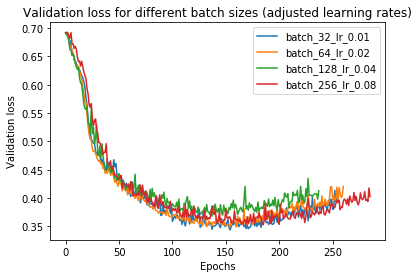

<Figure size 432x288 with 0 Axes>

In [103]:
# Plot losses for batch sizes, with learning rates adjusted
for batch_size, learning_rate in zip(batch_sizes, learning_rates):
    history = model_state_by_batch_size_and_learning_rate_trial_4[batch_size][learning_rate].history
    plt.plot(history['val_loss'], label='batch_{}_lr_{}'.format(batch_size, learning_rate))
plt.title('Validation loss for different batch sizes (adjusted learning rates)')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()
plt.show()
plt.savefig('graphs/validation_loss_by_batch_size_with_adjusted_lr')

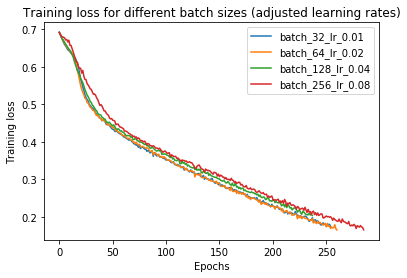

<Figure size 432x288 with 0 Axes>

In [104]:
# Plot losses for batch sizes, with learning rates adjusted
for batch_size, learning_rate in zip(batch_sizes, learning_rates):
    history = model_state_by_batch_size_and_learning_rate_trial_4[batch_size][learning_rate].history
    plt.plot(history['loss'], label='batch_{}_lr_{}'.format(batch_size, learning_rate))
plt.title('Training loss for different batch sizes (adjusted learning rates)')
plt.xlabel('Epochs')
plt.ylabel('Training loss')
plt.legend()
plt.show()
plt.savefig('graphs/training_loss_by_batch_size_with_adjusted_lr')

In [105]:
# Output losses for batch sizes, with learning rates adjusted
for batch_size, learning_rate in zip(batch_sizes, learning_rates):
    history = model_state_by_batch_size_and_learning_rate_trial_4[batch_size][learning_rate].history
    print("Batch size: {}, learning rate: {}, validation loss: {}, training loss: {}".format(
        batch_size,
        learning_rate,
        np.min(history['val_loss']),
        np.min(history['loss']),
    ))

Batch size: 32, learning rate: 0.01, validation loss: 0.3438840186963343, training loss: 0.17416517792819072
Batch size: 64, learning rate: 0.02, validation loss: 0.34903702976768963, training loss: 0.16469708632263427
Batch size: 128, learning rate: 0.04, validation loss: 0.36807054442328374, training loss: 0.20308066227787094
Batch size: 256, learning rate: 0.08, validation loss: 0.3529147537131059, training loss: 0.16489649720085622


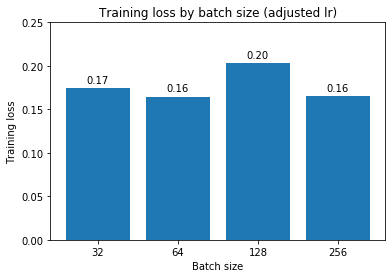

<Figure size 432x288 with 0 Axes>

In [109]:
# Plot training losses for batch sizes, with learning rates adjusted
training_losses = []
for batch_size, learning_rate in zip(batch_sizes, learning_rates):
    history = model_state_by_batch_size_and_learning_rate_trial_4[batch_size][learning_rate].history
    training_losses.append(np.min(history['loss']))
rects = plt.bar(x=range(len(batch_sizes)), height=training_losses, tick_label=batch_sizes)
autolabel(rects)
plt.xlabel('Batch size')
plt.ylabel('Training loss')
plt.ylim(0, 0.25)
plt.title('Training loss by batch size (adjusted lr)')
plt.show()
plt.savefig('graphs/training_loss_by_batch_size_with_adjusted_lr')

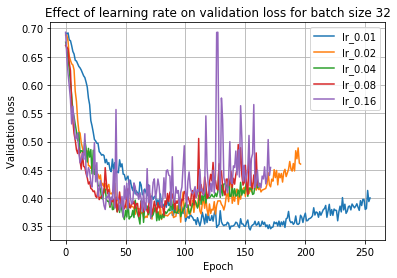

<Figure size 432x288 with 0 Axes>

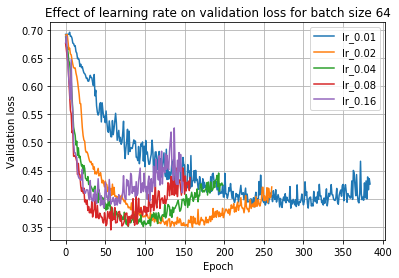

<Figure size 432x288 with 0 Axes>

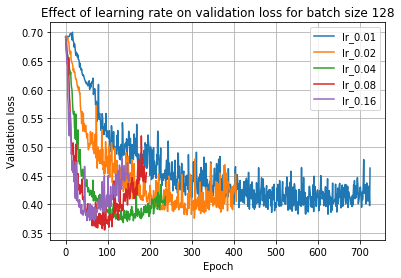

<Figure size 432x288 with 0 Axes>

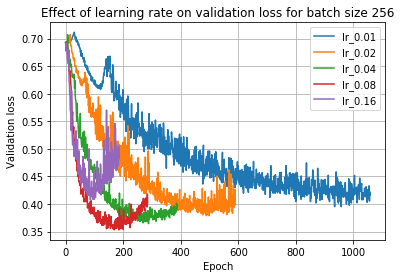

<Figure size 432x288 with 0 Axes>

In [110]:
# Visualize effect of learning rate for each batch size
for batch_size in batch_sizes:
    plt.figure()
    for learning_rate in learning_rates:
        history = model_state_by_batch_size_and_learning_rate_trial_4[batch_size][learning_rate].history
        plt.plot(history['val_loss'], label='lr_{}'.format(learning_rate))
        plt.xlabel('Epoch')
        plt.ylabel('Validation loss')
        plt.title('Effect of learning rate on validation loss for batch size {}'.format(batch_size))
        plt.grid(True)
        plt.legend(loc='best')
    plt.show()
    plt.savefig('graphs/batch_size_{}_lr_all'.format(batch_size))

We can see the effect of learning rate on different batch sizes above. Looking at the smallest batch size, 32, we see that the optimal learning rate is 0.01. On the other hand, for batch size 256, the optimal value is 0.08.

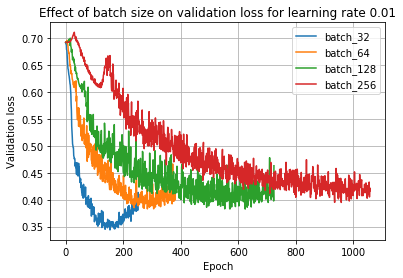

<Figure size 432x288 with 0 Axes>

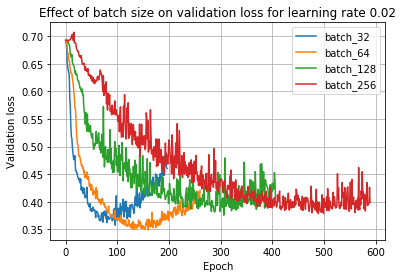

<Figure size 432x288 with 0 Axes>

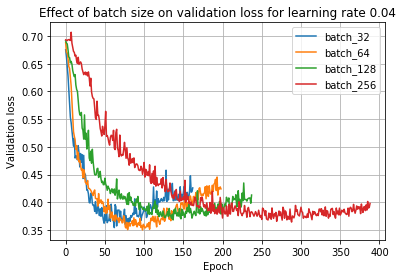

<Figure size 432x288 with 0 Axes>

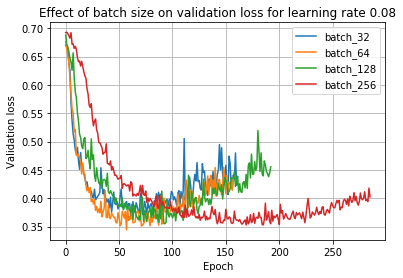

<Figure size 432x288 with 0 Axes>

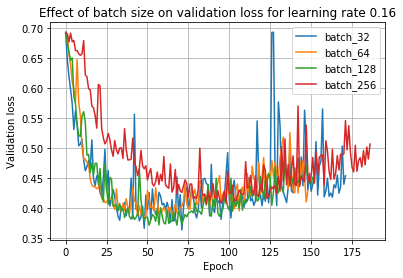

<Figure size 432x288 with 0 Axes>

In [111]:
# Visualize effect of batch size for each learning rate
for learning_rate in learning_rates:
    plt.figure()
    for batch_size in batch_sizes:
        history = model_state_by_batch_size_and_learning_rate_trial_4[batch_size][learning_rate].history
        plt.plot(history['val_loss'], label='batch_{}'.format(batch_size))
        plt.xlabel('Epoch')
        plt.ylabel('Validation loss')
        plt.title('Effect of batch size on validation loss for learning rate {}'.format(learning_rate))
        plt.grid(True)
        plt.legend(loc='best')
    plt.show()
    plt.savefig('graphs/batch_size_all_lr_{:.0f}_e-2'.format(learning_rate*100))

We see that for low learning rates such as 0.01, small batch sizes perform the best, whereas for higher learning rates, the larger batch sizes perform better.

The graphs below attempt to visualize this more succintly.

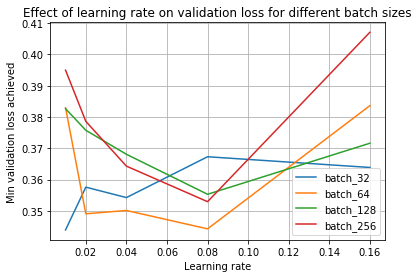

<Figure size 432x288 with 0 Axes>

In [112]:
# Visualize min val loss achieved by learning rate, for each batch size
plt.figure()
for batch_size in batch_sizes:
    min_val_losses = []
    for learning_rate in learning_rates:
        history = model_state_by_batch_size_and_learning_rate_trial_4[batch_size][learning_rate].history
        min_val_losses.append(np.min(history['val_loss']))
    plt.plot(learning_rates, min_val_losses, label='batch_{}'.format(batch_size))
    plt.xlabel('Learning rate')
    plt.ylabel('Min validation loss achieved')
    plt.title('Effect of learning rate on validation loss for different batch sizes')
    plt.grid(True)
    plt.legend(loc='best')
plt.show()
plt.savefig("graphs/min_val_loss_group_by_batch_size")

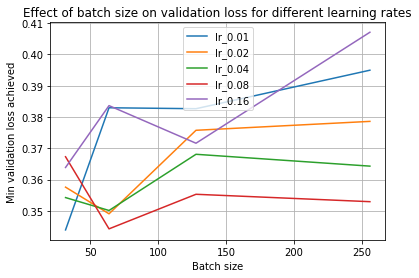

<Figure size 432x288 with 0 Axes>

In [51]:
# Visualize min val loss achieved by learning rate, for each batch size
plt.figure()
for learning_rate in learning_rates:
    min_val_losses = []
    for batch_size in batch_sizes:
        history = model_state_by_batch_size_and_learning_rate_trial_4[batch_size][learning_rate].history
        min_val_losses.append(np.min(history['val_loss']))
    plt.plot(batch_sizes, min_val_losses, label='lr_{}'.format(learning_rate))
    plt.xlabel('Batch size')
    plt.ylabel('Min validation loss achieved')
    plt.title('Effect of batch size on validation loss for different learning rates')
    plt.grid(True)
    plt.legend(loc='best')
plt.show()
plt.savefig("graphs/min_val_loss_group_by_learning_rate")

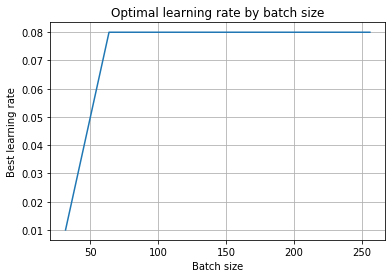

<Figure size 432x288 with 0 Axes>

In [59]:
plt.figure()
y_values = []
for batch_size in batch_sizes:
    min_val_losses = {}
    for learning_rate in learning_rates:
        history = model_state_by_batch_size_and_learning_rate_trial_4[batch_size][learning_rate].history
        min_val_losses[learning_rate] = np.min(history['val_loss'])
    best_learning_rate = min(min_val_losses.items(), key=lambda x: x[1])[0]
    y_values.append(best_learning_rate)

plt.plot(batch_sizes, y_values)
plt.xlabel('Batch size')
plt.ylabel('Best learning rate')
plt.title('Optimal learning rate by batch size')
plt.grid(True)
plt.show()
plt.savefig("graphs/optimal_lr_by_batch_size")

## Compute distance from initial weights and sharpness (lr adjusted)

In [136]:
new_distances = []
for batch_size, learning_rate in zip(batch_sizes, learning_rates):
    flattened_initial_weights = np.concatenate([w.flatten() for w in initial_weights])
    weights = models_by_batch_size_and_learning_rate[batch_size][learning_rate].get_weights()
    flattened_weights = np.concatenate([w.flatten() for w in weights])
    distance = np.linalg.norm(flattened_weights - flattened_initial_weights)
    new_distances.append(distance)
    print("Distance from initial weights for batch size {} at learning rate {}: {}".format(
        batch_size,learning_rate, distance))

Distance from initial weights for batch size 32 at learning rate 0.01: 12.450722694396973
Distance from initial weights for batch size 64 at learning rate 0.02: 12.943363189697266
Distance from initial weights for batch size 128 at learning rate 0.04: 11.441107749938965
Distance from initial weights for batch size 256 at learning rate 0.08: 14.155213356018066


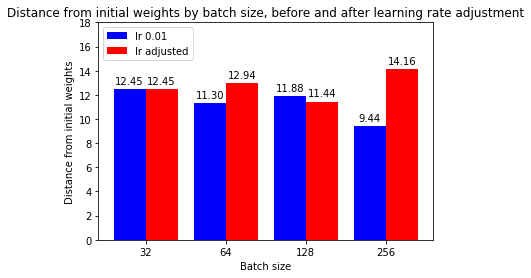

<Figure size 432x288 with 0 Axes>

In [140]:
rects_old = plt.bar(
    np.arange(0, len(batch_sizes))-0.4,
    distances,
    width=0.4,
    tick_label=batch_sizes,
    align='edge',
    color='b',
    label='lr 0.01'
)
rects_new = plt.bar(
    np.arange(0, len(batch_sizes)),
    new_distances,
    width=0.4,
    tick_label=batch_sizes,
    align='edge',
    color='r',
    label='lr adjusted'
)
autolabel(rects_old)
autolabel(rects_new)
plt.ylabel('Distance from initial weights')
plt.yticks(np.arange(0, 20, 2))
plt.xlabel('Batch size')
plt.title('Distance from initial weights by batch size, before and after learning rate adjustment')
plt.legend(loc='upper left')
plt.show()
plt.savefig('graphs/distance_by_batch_lr_adjusted')

In [115]:
# Get sharpness for each batch size (lr-adjusted)
new_sharpnesses = []
for batch_size, learning_rate in zip(batch_sizes, learning_rates):
    model = models_by_batch_size_and_learning_rate[batch_size][learning_rate]
    sharpness = ml_utils.get_sharpness(model, default_train, 1e-3)
    new_sharpnesses.append(sharpness)
    print("\nSharpness for batch size {} at learning rate {}: {}".format(batch_size, learning_rate, sharpness))

     19/Unknown - 3s 142ms/step - loss: 0.2337 - accuracy: 0.9037
Sharpness for batch size 32 at learning rate 0.01: 1.1427959690499176
     19/Unknown - 3s 142ms/step - loss: 0.2733 - accuracy: 0.8913
Sharpness for batch size 64 at learning rate 0.02: 6.266784457428905
     19/Unknown - 3s 140ms/step - loss: 0.2994 - accuracy: 0.8773
Sharpness for batch size 128 at learning rate 0.04: 4.298321295340472
     19/Unknown - 3s 139ms/step - loss: 0.2363 - accuracy: 0.9019
Sharpness for batch size 256 at learning rate 0.08: 4.099133262825729


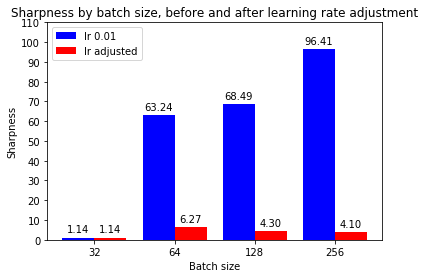

<Figure size 432x288 with 0 Axes>

In [138]:
rects_old = plt.bar(
    np.arange(0, len(batch_sizes))-0.4,
    sharpnesses,
    width=0.4,
    tick_label=batch_sizes,
    align='edge',
    color='b',
    label='lr 0.01'
)
rects_new = plt.bar(
    np.arange(0, len(batch_sizes)),
    new_sharpnesses,
    width=0.4,
    tick_label=batch_sizes,
    align='edge',
    color='r',
    label='lr adjusted'
)
autolabel(rects_old)
autolabel(rects_new)
plt.ylabel('Sharpness')
plt.yticks(np.arange(0, 120, 10))
plt.xlabel('Batch size')
plt.title('Sharpness by batch size, before and after learning rate adjustment')
plt.legend()
plt.show()
plt.savefig('graphs/sharpness_by_batch_lr_adjusted')

## Conclusion

So, what does this all mean? Does batch size matter when I'm training a model? Let's look at the best validation loss we achieved on each batch size and see.

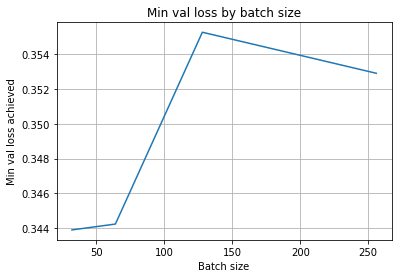

<Figure size 432x288 with 0 Axes>

In [63]:
plt.figure()
y_values = []
for batch_size in batch_sizes:
    min_val_losses = {}
    for learning_rate in learning_rates:
        history = model_state_by_batch_size_and_learning_rate_trial_4[batch_size][learning_rate].history
        min_val_losses[learning_rate] = np.min(history['val_loss'])
    min_val_loss_overall = min(min_val_losses.items(), key=lambda x: x[1])[1]
    y_values.append(min_val_loss_overall)

plt.plot(batch_sizes, y_values)
plt.xlabel('Batch size')
plt.ylabel('Min val loss achieved')
plt.title('Min val loss by batch size')
plt.grid(True)
plt.show()
plt.savefig("graphs/min_val_loss_by_batch_size")

Surprisingly, performance across different batch sizes is quite close! We do see that generally the larger the batch size the worse the performance, but the difference is not that large, compared to the difference observed with learning rate, for example. This suggests that as long as you find the right learning rate for your batch size, you should be fine; you can concentrate on other aspects of training. However, if you want to wring out every last drop of performance, you can do so by reducing the batch size.

**The tl;dr from the batch experiments so far is that batch size is closely linked to learning rate - the larger the batch size, the larger the optimal learning rate. The experiments suggest that as long as you find the optimal learning rate for a given batch size, the difference in performance between batch sizes is actually not that large.**

Some other questions to explore:
- How does Keras handle batch udpates? Does it average the gradients over a batch, or sum them?
- Why is the ratio of the batch-level update magnitude almost exactly the inverse of the batch size?

## Old runs

## Try different batch sizes

Let's first start off testing two batch sizes - small (32) and large (256). We would expect the large batch size to achieve similar training loss but poorer validation loss. This generalization gap is described in https://arxiv.org/pdf/1609.04836.pdf. We would also expect the large batch size to train somewhat faster.

In [6]:
batch_sizes = [32, 256]
model_state_by_batch_size_trial_1 = {}

for batch_size in batch_sizes:
    # Read training data
    train, validation = ml_utils.load_batched_and_resized_dataset(
        dataset_name='cats_vs_dogs',   
        batch_size=batch_size,
        img_size=128
    )

    # Build and train model
    model = ml_utils.build_model()
    es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
    mc = keras.callbacks.ModelCheckpoint(
        'pickled_objects/batch_size_{}_best_model_trial_1.h5'.format(batch_size),
        monitor='val_loss',
        mode='min',
        verbose=1,
        save_best_only=True,
    )
    model_state_by_batch_size_trial_1[batch_size] = ml_utils.train_model(
        model,
        train,
        validation,
        epochs=1000,
        extra_callbacks=[es, mc],
    )

Training Data Summary
No. of examples: 18610
Class: 0 :::: Count: 9378 :::: Percentage: 50.39226222461043
Class: 1 :::: Count: 9232 :::: Percentage: 49.60773777538957

Validation Data Summary
No. of examples: 4652
Class: 0 :::: Count: 2280 :::: Percentage: 49.011177987962164
Class: 1 :::: Count: 2372 :::: Percentage: 50.988822012037836
Epoch 1/1000
    582/Unknown - 25s 43ms/step - loss: 0.6877 - accuracy: 0.5366
Epoch 00001: val_loss improved from inf to 0.67004, saving model to pickled_objects/batch_size_32_best_model_trial_1.h5
582/582 [==============================] - 31s 53ms/step - loss: 0.6877 - accuracy: 0.5366 - val_loss: 0.6700 - val_accuracy: 0.6159
Epoch 2/1000
580/582 [============================>.] - ETA: 0s - loss: 0.6765 - accuracy: 0.5647
Epoch 00002: val_loss improved from 0.67004 to 0.65121, saving model to pickled_objects/batch_size_32_best_model_trial_1.h5
582/582 [==============================] - 12s 21ms/step - loss: 0.6764 - accuracy: 0.5651 - val_loss: 0.651

In [11]:
ml_utils.save_model_state(model_state_by_batch_size_trial_1, 'model_state_by_batch_size_trial_1')

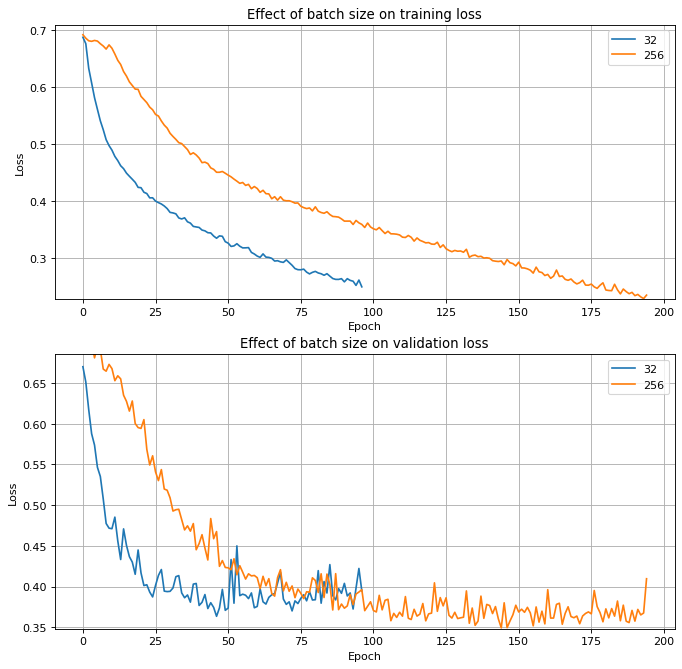

<Figure size 432x288 with 0 Axes>

In [6]:
ml_utils.plot_loss_by_param(model_state_by_batch_size_trial_1, 'batch size', 'batch_size_loss_trial_1')

We see that indeed the large batch size trains faster (~8s vs ~13s). However, the larger batch size actually achieves a better validation loss than the small batch size! One possible cause is that the learning rate is too high - in general, the accepted rule of thumb is to scale learning rate linearly with batch size. Let's try a smaller learning rate and see.

But before we do that, let's also evaluate two claims made by the paper linked above:
1) Large batch size runs converge to weights that tend to be closer to the initial weights.
2) Large batch size runs find sharp minimizers (minima that vary sharply as you move away from them), whereas small batch sizes find flat minimizers.

In [17]:
initial_weights = ml_utils.build_model().get_weights()

batch_32_model = load_model('pickled_objects/batch_size_32_best_model_trial_1.h5')
batch_32_weights = batch_32_model.get_weights()

batch_256_model = load_model('pickled_objects/batch_size_256_best_model_trial_1.h5')
batch_256_weights = batch_256_model.get_weights()

In [8]:
for i in range(len(initial_weights)):
    print("Parameter set:", i)
    print("\tDistance from batch 32 to initial: ", np.linalg.norm(batch_32_weights[i] - initial_weights[i]))
    print("\tDistance from batch 256 to initial: ", np.linalg.norm(batch_256_weights[i] - initial_weights[i]))

Parameter set: 0
	Distance from batch 32 to initial:  7.571703
	Distance from batch 256 to initial:  5.3802633
Parameter set: 1
	Distance from batch 32 to initial:  1.607382
	Distance from batch 256 to initial:  0.7609598
Parameter set: 2
	Distance from batch 32 to initial:  5.264128
	Distance from batch 256 to initial:  3.741805
Parameter set: 3
	Distance from batch 32 to initial:  0.6104848
	Distance from batch 256 to initial:  0.6706511
Parameter set: 4
	Distance from batch 32 to initial:  6.984695
	Distance from batch 256 to initial:  3.811523
Parameter set: 5
	Distance from batch 32 to initial:  1.6693754
	Distance from batch 256 to initial:  0.95895517
Parameter set: 6
	Distance from batch 32 to initial:  8.322372
	Distance from batch 256 to initial:  4.621147
Parameter set: 7
	Distance from batch 32 to initial:  3.2356453
	Distance from batch 256 to initial:  1.2127824
Parameter set: 8
	Distance from batch 32 to initial:  11.968357
	Distance from batch 256 to initial:  6.4350142

In [9]:
flattened_initial_weights = np.concatenate([x.flatten() for x in initial_weights])
flattened_32_weights = np.concatenate([x.flatten() for x in batch_32_weights])
flattened_256_weights = np.concatenate([x.flatten() for x in batch_256_weights])

In [10]:
print(
    "Distance from flattened batch 32 weights to initial weights: ",
    np.linalg.norm(flattened_32_weights - flattened_initial_weights)
)

Distance from flattened batch 32 weights to initial weights:  26.302883


In [11]:
print(
    "Distance from flattened batch 256 weights to initial weights: ",
    np.linalg.norm(flattened_256_weights - flattened_initial_weights)
)

Distance from flattened batch 256 weights to initial weights:  13.724105


We see that indeed, the larger batch size converged to weights that were closer to the initial weights (distance of 12 vs 25).

How about if we look at the linear interpolation between the two minima?

In [13]:
alpha_values = np.linspace(-1, 1.5, 20)
training_losses = []
validation_losses = []
for alpha in alpha_values:
    print("\nTesting alpha: ", alpha)
    model = ml_utils.build_model()
    target_weights = [batch_256_weights[i]*alpha + batch_32_weights[i]*(1-alpha) for i in range(len(batch_32_weights))]
    model.set_weights(target_weights)
    training_loss, training_accuracy = model.evaluate(default_train)
    validation_loss, validation_accuracy = model.evaluate(default_validation)
    training_losses.append(training_loss)
    validation_losses.append(validation_loss)


Testing alpha:  -1.0
      5/Unknown - 6s 1s/step - loss: 4.2154 - accuracy: 0.6341
Testing alpha:  -0.868421052631579
      5/Unknown - 1s 143ms/step - loss: 2.5390 - accuracy: 0.6449
Testing alpha:  -0.736842105263158
      5/Unknown - 1s 141ms/step - loss: 1.5776 - accuracy: 0.6591
Testing alpha:  -0.6052631578947368
      5/Unknown - 1s 139ms/step - loss: 1.0382 - accuracy: 0.6844
Testing alpha:  -0.4736842105263158
      5/Unknown - 1s 142ms/step - loss: 0.7170 - accuracy: 0.7242
Testing alpha:  -0.3421052631578948
      5/Unknown - 1s 144ms/step - loss: 0.5082 - accuracy: 0.7773
Testing alpha:  -0.21052631578947367
      5/Unknown - 1s 138ms/step - loss: 0.3949 - accuracy: 0.8169
Testing alpha:  -0.07894736842105265
      5/Unknown - 1s 147ms/step - loss: 0.3578 - accuracy: 0.8375
Testing alpha:  0.05263157894736836
      5/Unknown - 1s 143ms/step - loss: 0.3736 - accuracy: 0.8310
Testing alpha:  0.18421052631578938
      5/Unknown - 1s 144ms/step - loss: 0.4306 - accuracy: 0.80

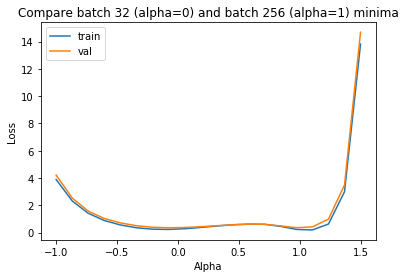

<Figure size 432x288 with 0 Axes>

In [14]:
plt.plot(alpha_values, training_losses, label='train')
plt.plot(alpha_values, validation_losses, label='val')
plt.title("Compare batch 32 (alpha=0) and batch 256 (alpha=1) minima")
plt.xlabel("Alpha")
plt.ylabel("Loss")
plt.legend()
plt.show()
plt.savefig('graphs/batch_size_alpha_trial_1')

We see here that the larger batch size minimum (alpha=1) changes much more sharply than the other one (alpha=0).

Now, how about computing the sharpness of each minimum numerically?

In [10]:
batch_32_sharpness = ml_utils.get_sharpness(batch_32_model, default_train)
batch_256_sharpness = ml_utils.get_sharpness(batch_256_model, default_train)
print("\nBatch 32 sharpness: {:e}, batch 256 sharpness: {:e}".format(
    batch_32_sharpness,
    batch_256_sharpness,
))

     19/Unknown - 3s 140ms/step - loss: 74.2251 - accuracy: 0.5062
Batch 32 sharpness: 4.496556e+02, batch 256 sharpness: 6.136774e+03


Looking at the sharpness scores, we observe that the large batch size found a sharp minimizer, as predicted by the paper.

Now, let's try plotting the filter-normalized plots for both of these minimizers.


x:  -1.0
      5/Unknown - 6s 1s/step - loss: 1.0887 - accuracy: 0.6094
x:  -0.8947368421052632
      5/Unknown - 1s 141ms/step - loss: 0.9127 - accuracy: 0.6311
x:  -0.7894736842105263
      5/Unknown - 1s 145ms/step - loss: 0.7772 - accuracy: 0.6567
x:  -0.6842105263157895
      5/Unknown - 1s 140ms/step - loss: 0.6627 - accuracy: 0.6939
x:  -0.5789473684210527
      5/Unknown - 1s 139ms/step - loss: 0.5619 - accuracy: 0.7307
x:  -0.4736842105263158
      5/Unknown - 1s 142ms/step - loss: 0.4859 - accuracy: 0.7653
x:  -0.368421052631579
      5/Unknown - 1s 142ms/step - loss: 0.4311 - accuracy: 0.7954
x:  -0.26315789473684215
      5/Unknown - 1s 142ms/step - loss: 0.3950 - accuracy: 0.8173
x:  -0.1578947368421053
      5/Unknown - 1s 143ms/step - loss: 0.3730 - accuracy: 0.8300
x:  -0.052631578947368474
      5/Unknown - 1s 141ms/step - loss: 0.3627 - accuracy: 0.8343
x:  0.05263157894736836
      5/Unknown - 1s 141ms/step - loss: 0.3638 - accuracy: 0.8356
x:  0.1578947368421053
  

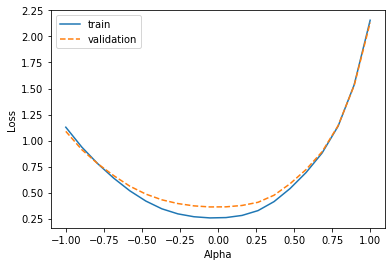

In [12]:
x_values, batch_32_train_losses, batch_32_validation_losses = \
ml_utils.plot_loss_visualization_1d(batch_32_model, default_train, default_validation)


x:  -1.0
      5/Unknown - 1s 143ms/step - loss: 1.0214 - accuracy: 0.6412
x:  -0.8947368421052632
      5/Unknown - 1s 138ms/step - loss: 0.7589 - accuracy: 0.6885
x:  -0.7894736842105263
      5/Unknown - 1s 135ms/step - loss: 0.6432 - accuracy: 0.7132
x:  -0.6842105263157895
      5/Unknown - 1s 140ms/step - loss: 0.5695 - accuracy: 0.7410
x:  -0.5789473684210527
      5/Unknown - 1s 147ms/step - loss: 0.5075 - accuracy: 0.7681
x:  -0.4736842105263158
      5/Unknown - 1s 144ms/step - loss: 0.4507 - accuracy: 0.7951
x:  -0.368421052631579
      5/Unknown - 1s 141ms/step - loss: 0.4089 - accuracy: 0.8162
x:  -0.26315789473684215
      5/Unknown - 1s 146ms/step - loss: 0.3804 - accuracy: 0.8289
x:  -0.1578947368421053
      5/Unknown - 1s 145ms/step - loss: 0.3613 - accuracy: 0.8375
x:  -0.052631578947368474
      5/Unknown - 1s 140ms/step - loss: 0.3527 - accuracy: 0.8416
x:  0.05263157894736836
      5/Unknown - 1s 144ms/step - loss: 0.3574 - accuracy: 0.8383
x:  0.1578947368421053

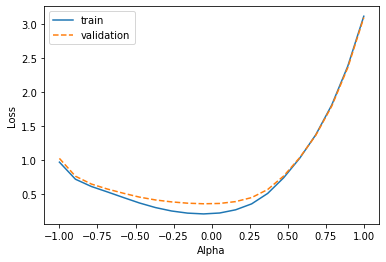

In [13]:
x_values, batch_256_train_losses, batch_256_validation_losses = \
ml_utils.plot_loss_visualization_1d(batch_256_model, default_train, default_validation)

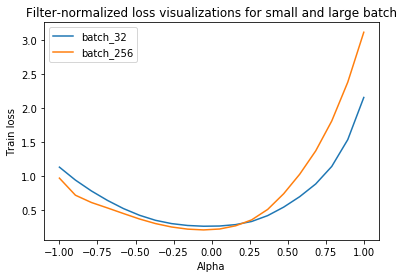

In [16]:
plt.plot(x_values, batch_32_train_losses, label='batch_32')
plt.plot(x_values, batch_256_train_losses, label='batch_256')
plt.ylabel('Train loss')
plt.xlabel('Alpha')
plt.title('Filter-normalized loss visualizations for small and large batch')
plt.legend()
plt.savefig('graphs/filter_normalized_loss_1d_for_small_and_large_batch')


 x: -1.0, y: -1.0
     19/Unknown - 3s 145ms/step - loss: 4.7419 - accuracy: 0.4926
 x: -0.5, y: -1.0
     19/Unknown - 3s 138ms/step - loss: 1.8410 - accuracy: 0.5649
 x: 0.0, y: -1.0
     19/Unknown - 3s 137ms/step - loss: 0.8300 - accuracy: 0.6541
 x: 0.5, y: -1.0
     19/Unknown - 3s 139ms/step - loss: 1.7869 - accuracy: 0.5262
 x: 1.0, y: -1.0
     19/Unknown - 3s 136ms/step - loss: 2.9362 - accuracy: 0.5238
 x: -1.0, y: -0.5
     19/Unknown - 3s 137ms/step - loss: 1.2615 - accuracy: 0.5360
 x: -0.5, y: -0.5
     19/Unknown - 3s 138ms/step - loss: 0.7971 - accuracy: 0.6509
 x: 0.0, y: -0.5
     19/Unknown - 3s 136ms/step - loss: 0.3552 - accuracy: 0.8408
 x: 0.5, y: -0.5
     19/Unknown - 3s 136ms/step - loss: 0.6093 - accuracy: 0.6841
 x: 1.0, y: -0.5
     19/Unknown - 3s 136ms/step - loss: 1.5683 - accuracy: 0.5303
 x: -1.0, y: 0.0
     19/Unknown - 3s 135ms/step - loss: 1.0255 - accuracy: 0.4896
 x: -0.5, y: 0.0
     19/Unknown - 3s 135ms/step - loss: 0.5220 - accuracy: 0.7395

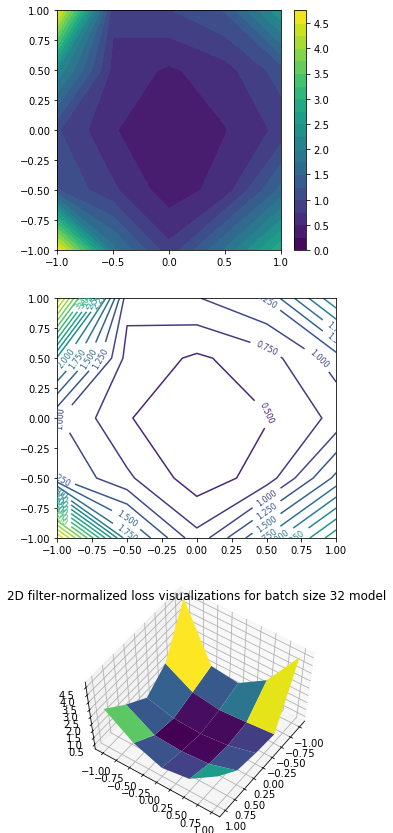

<Figure size 432x288 with 0 Axes>

In [20]:
X, Y, Z = ml_utils.plot_loss_visualization_2d(
    batch_32_model,
    default_train,
    mode='all',
    title='2D filter-normalized loss visualizations for batch size 32 model',
    output_filename='filter_normalized_loss_2d_for_batch_32',
)


 x: -1.0, y: -1.0
     19/Unknown - 3s 147ms/step - loss: 22.1901 - accuracy: 0.5038
 x: -0.5, y: -1.0
     19/Unknown - 3s 139ms/step - loss: 2.1813 - accuracy: 0.5408
 x: 0.0, y: -1.0
     19/Unknown - 3s 134ms/step - loss: 1.0046 - accuracy: 0.5712
 x: 0.5, y: -1.0
     19/Unknown - 3s 135ms/step - loss: 2.6657 - accuracy: 0.5049
 x: 1.0, y: -1.0
     19/Unknown - 3s 136ms/step - loss: 11.5595 - accuracy: 0.4976
 x: -1.0, y: -0.5
     19/Unknown - 3s 139ms/step - loss: 4.2271 - accuracy: 0.5050
 x: -0.5, y: -0.5
     19/Unknown - 3s 134ms/step - loss: 0.9102 - accuracy: 0.6091
 x: 0.0, y: -0.5
     19/Unknown - 3s 137ms/step - loss: 0.7868 - accuracy: 0.6211
 x: 0.5, y: -0.5
     19/Unknown - 3s 136ms/step - loss: 0.9597 - accuracy: 0.5582
 x: 1.0, y: -0.5
     19/Unknown - 3s 136ms/step - loss: 1.5068 - accuracy: 0.5749
 x: -1.0, y: 0.0
     19/Unknown - 3s 136ms/step - loss: 1.1258 - accuracy: 0.5256
 x: -0.5, y: 0.0
     19/Unknown - 3s 138ms/step - loss: 0.4490 - accuracy: 0.79

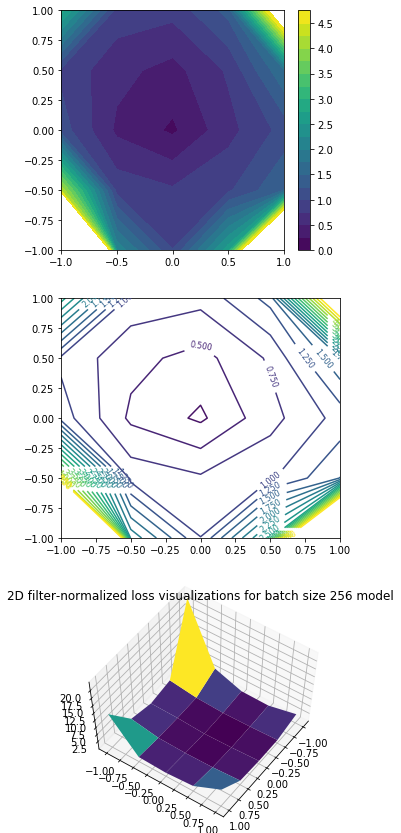

<Figure size 432x288 with 0 Axes>

In [21]:
X, Y, Z = ml_utils.plot_loss_visualization_2d(
    batch_256_model,
    default_train,
    mode='all',
    title='2D filter-normalized loss visualizations for batch size 256 model',
    output_filename='filter_normalized_loss_2d_for_batch_256',
)

## Use smaller learning rate

Now, let's use a smaller learning rate and see if that resolves the weird behavior we observed previously (large batch size outperforming small one).

In [13]:
batch_sizes = [32, 256]
model_state_by_batch_size_trial_2 = {}
        
for batch_size in batch_sizes:
    # Read training data
    train, validation = ml_utils.load_batched_and_resized_dataset(
        dataset_name='cats_vs_dogs',   
        batch_size=batch_size,
        img_size=128
    )

    # Build and train model
    model = ml_utils.build_model(optimizer=keras.optimizers.SGD(0.02))
    es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)
    mc = keras.callbacks.ModelCheckpoint(
        'pickled_objects/batch_size_{}_best_model_trial_2.h5'.format(batch_size),
        monitor='val_loss',
        mode='min',
        verbose=1,
        save_best_only=True,
    )
    model_state_by_batch_size_trial_2[batch_size] = ml_utils.train_model(
        model,
        train,
        validation,
        epochs=1000,
        extra_callbacks=[es, mc],
    )

Training Data Summary
No. of examples: 18610
Class: 0 :::: Count: 9378 :::: Percentage: 50.39226222461043
Class: 1 :::: Count: 9232 :::: Percentage: 49.60773777538957

Validation Data Summary
No. of examples: 4652
Class: 0 :::: Count: 2280 :::: Percentage: 49.011177987962164
Class: 1 :::: Count: 2372 :::: Percentage: 50.988822012037836
Epoch 1/1000
    582/Unknown - 28s 48ms/step - loss: 0.6912 - accuracy: 0.5260
Epoch 00001: val_loss improved from inf to 0.68999, saving model to pickled_objects/batch_size_32_best_model_trial_2.h5
582/582 [==============================] - 35s 60ms/step - loss: 0.6912 - accuracy: 0.5260 - val_loss: 0.6900 - val_accuracy: 0.5125
Epoch 2/1000
580/582 [============================>.] - ETA: 0s - loss: 0.6806 - accuracy: 0.5729
Epoch 00002: val_loss improved from 0.68999 to 0.68582, saving model to pickled_objects/batch_size_32_best_model_trial_2.h5
582/582 [==============================] - 12s 21ms/step - loss: 0.6806 - accuracy: 0.5728 - val_loss: 0.685

Epoch 24/1000
580/582 [============================>.] - ETA: 0s - loss: 0.4679 - accuracy: 0.7784
Epoch 00024: val_loss did not improve from 0.45468
582/582 [==============================] - 12s 21ms/step - loss: 0.4682 - accuracy: 0.7780 - val_loss: 0.4567 - val_accuracy: 0.7848
Epoch 25/1000
580/582 [============================>.] - ETA: 0s - loss: 0.4614 - accuracy: 0.7802
Epoch 00025: val_loss did not improve from 0.45468
582/582 [==============================] - 12s 21ms/step - loss: 0.4617 - accuracy: 0.7799 - val_loss: 0.4702 - val_accuracy: 0.7786
Epoch 26/1000
580/582 [============================>.] - ETA: 0s - loss: 0.4591 - accuracy: 0.7839
Epoch 00026: val_loss improved from 0.45468 to 0.44345, saving model to pickled_objects/batch_size_32_best_model_trial_2.h5
582/582 [==============================] - 12s 21ms/step - loss: 0.4594 - accuracy: 0.7837 - val_loss: 0.4435 - val_accuracy: 0.7930
Epoch 27/1000
580/582 [============================>.] - ETA: 0s - loss: 0.453

Epoch 51/1000
580/582 [============================>.] - ETA: 0s - loss: 0.3844 - accuracy: 0.8260
Epoch 00051: val_loss improved from 0.38784 to 0.38136, saving model to pickled_objects/batch_size_32_best_model_trial_2.h5
582/582 [==============================] - 12s 21ms/step - loss: 0.3844 - accuracy: 0.8258 - val_loss: 0.3814 - val_accuracy: 0.8242
Epoch 52/1000
580/582 [============================>.] - ETA: 0s - loss: 0.3787 - accuracy: 0.8275
Epoch 00052: val_loss did not improve from 0.38136
582/582 [==============================] - 12s 21ms/step - loss: 0.3787 - accuracy: 0.8275 - val_loss: 0.3853 - val_accuracy: 0.8218
Epoch 53/1000
580/582 [============================>.] - ETA: 0s - loss: 0.3781 - accuracy: 0.8297
Epoch 00053: val_loss did not improve from 0.38136
582/582 [==============================] - 12s 21ms/step - loss: 0.3781 - accuracy: 0.8297 - val_loss: 0.3875 - val_accuracy: 0.8218
Epoch 54/1000
580/582 [============================>.] - ETA: 0s - loss: 0.374

Epoch 106/1000
580/582 [============================>.] - ETA: 0s - loss: 0.2606 - accuracy: 0.8876
Epoch 00106: val_loss did not improve from 0.34435
582/582 [==============================] - 12s 21ms/step - loss: 0.2607 - accuracy: 0.8876 - val_loss: 0.3679 - val_accuracy: 0.8375
Epoch 107/1000
580/582 [============================>.] - ETA: 0s - loss: 0.2565 - accuracy: 0.8918
Epoch 00107: val_loss did not improve from 0.34435
582/582 [==============================] - 12s 21ms/step - loss: 0.2568 - accuracy: 0.8916 - val_loss: 0.3548 - val_accuracy: 0.8401
Epoch 108/1000
580/582 [============================>.] - ETA: 0s - loss: 0.2646 - accuracy: 0.8859
Epoch 00108: val_loss did not improve from 0.34435
582/582 [==============================] - 12s 21ms/step - loss: 0.2642 - accuracy: 0.8860 - val_loss: 0.3797 - val_accuracy: 0.8321
Epoch 109/1000
580/582 [============================>.] - ETA: 0s - loss: 0.2580 - accuracy: 0.8890
Epoch 00109: val_loss did not improve from 0.344

Epoch 135/1000
580/582 [============================>.] - ETA: 0s - loss: 0.2142 - accuracy: 0.9126
Epoch 00135: val_loss did not improve from 0.34435
582/582 [==============================] - 12s 21ms/step - loss: 0.2142 - accuracy: 0.9125 - val_loss: 0.3782 - val_accuracy: 0.8401
Epoch 136/1000
580/582 [============================>.] - ETA: 0s - loss: 0.2086 - accuracy: 0.9121
Epoch 00136: val_loss did not improve from 0.34435
582/582 [==============================] - 12s 21ms/step - loss: 0.2083 - accuracy: 0.9121 - val_loss: 0.3689 - val_accuracy: 0.8392
Epoch 137/1000
580/582 [============================>.] - ETA: 0s - loss: 0.2086 - accuracy: 0.9137
Epoch 00137: val_loss did not improve from 0.34435
582/582 [==============================] - 12s 21ms/step - loss: 0.2084 - accuracy: 0.9137 - val_loss: 0.4103 - val_accuracy: 0.8274
Epoch 138/1000
580/582 [============================>.] - ETA: 0s - loss: 0.2040 - accuracy: 0.9154
Epoch 00138: val_loss did not improve from 0.344

Epoch 164/1000
580/582 [============================>.] - ETA: 0s - loss: 0.1710 - accuracy: 0.9321
Epoch 00164: val_loss did not improve from 0.34435
582/582 [==============================] - 12s 21ms/step - loss: 0.1707 - accuracy: 0.9321 - val_loss: 0.4020 - val_accuracy: 0.8407
Epoch 165/1000
580/582 [============================>.] - ETA: 0s - loss: 0.1737 - accuracy: 0.9294
Epoch 00165: val_loss did not improve from 0.34435
582/582 [==============================] - 12s 21ms/step - loss: 0.1737 - accuracy: 0.9292 - val_loss: 0.3863 - val_accuracy: 0.8448
Epoch 166/1000
580/582 [============================>.] - ETA: 0s - loss: 0.1643 - accuracy: 0.9336
Epoch 00166: val_loss did not improve from 0.34435
582/582 [==============================] - 12s 21ms/step - loss: 0.1644 - accuracy: 0.9335 - val_loss: 0.4095 - val_accuracy: 0.8347
Epoch 167/1000
580/582 [============================>.] - ETA: 0s - loss: 0.1731 - accuracy: 0.9321
Epoch 00167: val_loss did not improve from 0.344

Epoch 00192: early stopping
Training Data Summary
No. of examples: 18610
Class: 0 :::: Count: 9378 :::: Percentage: 50.39226222461043
Class: 1 :::: Count: 9232 :::: Percentage: 49.60773777538957

Validation Data Summary
No. of examples: 4652
Class: 0 :::: Count: 2280 :::: Percentage: 49.011177987962164
Class: 1 :::: Count: 2372 :::: Percentage: 50.988822012037836
Epoch 1/1000
     73/Unknown - 24s 323ms/step - loss: 0.6939 - accuracy: 0.4975
Epoch 00001: val_loss improved from inf to 0.69307, saving model to pickled_objects/batch_size_256_best_model_trial_2.h5
73/73 [==============================] - 30s 412ms/step - loss: 0.6939 - accuracy: 0.4975 - val_loss: 0.6931 - val_accuracy: 0.5142
Epoch 2/1000
72/73 [============================>.] - ETA: 0s - loss: 0.6929 - accuracy: 0.5084
Epoch 00002: val_loss improved from 0.69307 to 0.69269, saving model to pickled_objects/batch_size_256_best_model_trial_2.h5
73/73 [==============================] - 8s 109ms/step - loss: 0.6929 - accuracy

Epoch 27/1000
72/73 [============================>.] - ETA: 0s - loss: 0.6510 - accuracy: 0.6087
Epoch 00027: val_loss improved from 0.67132 to 0.66912, saving model to pickled_objects/batch_size_256_best_model_trial_2.h5
73/73 [==============================] - 8s 107ms/step - loss: 0.6507 - accuracy: 0.6095 - val_loss: 0.6691 - val_accuracy: 0.5840
Epoch 28/1000
72/73 [============================>.] - ETA: 0s - loss: 0.6508 - accuracy: 0.6131
Epoch 00028: val_loss improved from 0.66912 to 0.66818, saving model to pickled_objects/batch_size_256_best_model_trial_2.h5
73/73 [==============================] - 8s 107ms/step - loss: 0.6504 - accuracy: 0.6138 - val_loss: 0.6682 - val_accuracy: 0.5853
Epoch 29/1000
72/73 [============================>.] - ETA: 0s - loss: 0.6490 - accuracy: 0.6139
Epoch 00029: val_loss improved from 0.66818 to 0.66629, saving model to pickled_objects/batch_size_256_best_model_trial_2.h5
73/73 [==============================] - 8s 107ms/step - loss: 0.6487 - 

Epoch 53/1000
72/73 [============================>.] - ETA: 0s - loss: 0.6236 - accuracy: 0.6442
Epoch 00053: val_loss did not improve from 0.62717
73/73 [==============================] - 8s 107ms/step - loss: 0.6237 - accuracy: 0.6441 - val_loss: 0.6323 - val_accuracy: 0.6313
Epoch 54/1000
72/73 [============================>.] - ETA: 0s - loss: 0.6219 - accuracy: 0.6458
Epoch 00054: val_loss did not improve from 0.62717
73/73 [==============================] - 8s 108ms/step - loss: 0.6221 - accuracy: 0.6455 - val_loss: 0.6358 - val_accuracy: 0.6253
Epoch 55/1000
72/73 [============================>.] - ETA: 0s - loss: 0.6197 - accuracy: 0.6522
Epoch 00055: val_loss improved from 0.62717 to 0.62451, saving model to pickled_objects/batch_size_256_best_model_trial_2.h5
73/73 [==============================] - 8s 109ms/step - loss: 0.6197 - accuracy: 0.6521 - val_loss: 0.6245 - val_accuracy: 0.6389
Epoch 56/1000
72/73 [============================>.] - ETA: 0s - loss: 0.6175 - accuracy:

Epoch 82/1000
72/73 [============================>.] - ETA: 0s - loss: 0.5530 - accuracy: 0.7142
Epoch 00082: val_loss improved from 0.60570 to 0.57458, saving model to pickled_objects/batch_size_256_best_model_trial_2.h5
73/73 [==============================] - 8s 107ms/step - loss: 0.5538 - accuracy: 0.7139 - val_loss: 0.5746 - val_accuracy: 0.6776
Epoch 83/1000
72/73 [============================>.] - ETA: 0s - loss: 0.5499 - accuracy: 0.7153
Epoch 00083: val_loss did not improve from 0.57458
73/73 [==============================] - 8s 107ms/step - loss: 0.5508 - accuracy: 0.7146 - val_loss: 0.6102 - val_accuracy: 0.6528
Epoch 84/1000
72/73 [============================>.] - ETA: 0s - loss: 0.5498 - accuracy: 0.7184
Epoch 00084: val_loss did not improve from 0.57458
73/73 [==============================] - 8s 107ms/step - loss: 0.5503 - accuracy: 0.7178 - val_loss: 0.6048 - val_accuracy: 0.6533
Epoch 85/1000
72/73 [============================>.] - ETA: 0s - loss: 0.5485 - accuracy:

Epoch 110/1000
72/73 [============================>.] - ETA: 0s - loss: 0.5173 - accuracy: 0.7433
Epoch 00110: val_loss did not improve from 0.52323
73/73 [==============================] - 8s 108ms/step - loss: 0.5181 - accuracy: 0.7426 - val_loss: 0.5263 - val_accuracy: 0.7291
Epoch 111/1000
72/73 [============================>.] - ETA: 0s - loss: 0.5203 - accuracy: 0.7393
Epoch 00111: val_loss did not improve from 0.52323
73/73 [==============================] - 8s 108ms/step - loss: 0.5211 - accuracy: 0.7387 - val_loss: 0.5643 - val_accuracy: 0.6930
Epoch 112/1000
72/73 [============================>.] - ETA: 0s - loss: 0.5187 - accuracy: 0.7407
Epoch 00112: val_loss did not improve from 0.52323
73/73 [==============================] - 8s 108ms/step - loss: 0.5197 - accuracy: 0.7400 - val_loss: 0.5259 - val_accuracy: 0.7238
Epoch 113/1000
72/73 [============================>.] - ETA: 0s - loss: 0.5152 - accuracy: 0.7448
Epoch 00113: val_loss did not improve from 0.52323
73/73 [====

Epoch 139/1000
72/73 [============================>.] - ETA: 0s - loss: 0.4961 - accuracy: 0.7561
Epoch 00139: val_loss did not improve from 0.49626
73/73 [==============================] - 8s 107ms/step - loss: 0.4969 - accuracy: 0.7556 - val_loss: 0.5175 - val_accuracy: 0.7328
Epoch 140/1000
72/73 [============================>.] - ETA: 0s - loss: 0.4909 - accuracy: 0.7606
Epoch 00140: val_loss did not improve from 0.49626
73/73 [==============================] - 8s 107ms/step - loss: 0.4915 - accuracy: 0.7602 - val_loss: 0.5205 - val_accuracy: 0.7319
Epoch 141/1000
72/73 [============================>.] - ETA: 0s - loss: 0.4956 - accuracy: 0.7572
Epoch 00141: val_loss did not improve from 0.49626
73/73 [==============================] - 8s 107ms/step - loss: 0.4962 - accuracy: 0.7569 - val_loss: 0.5108 - val_accuracy: 0.7390
Epoch 142/1000
72/73 [============================>.] - ETA: 0s - loss: 0.4936 - accuracy: 0.7601
Epoch 00142: val_loss did not improve from 0.49626
73/73 [====

Epoch 168/1000
72/73 [============================>.] - ETA: 0s - loss: 0.4790 - accuracy: 0.7702
Epoch 00168: val_loss did not improve from 0.48174
73/73 [==============================] - 8s 107ms/step - loss: 0.4797 - accuracy: 0.7702 - val_loss: 0.5171 - val_accuracy: 0.7347
Epoch 169/1000
72/73 [============================>.] - ETA: 0s - loss: 0.4750 - accuracy: 0.7702
Epoch 00169: val_loss did not improve from 0.48174
73/73 [==============================] - 8s 108ms/step - loss: 0.4758 - accuracy: 0.7700 - val_loss: 0.4966 - val_accuracy: 0.7487
Epoch 170/1000
72/73 [============================>.] - ETA: 0s - loss: 0.4775 - accuracy: 0.7689
Epoch 00170: val_loss improved from 0.48174 to 0.47119, saving model to pickled_objects/batch_size_256_best_model_trial_2.h5
73/73 [==============================] - 8s 108ms/step - loss: 0.4781 - accuracy: 0.7688 - val_loss: 0.4712 - val_accuracy: 0.7668
Epoch 171/1000
72/73 [============================>.] - ETA: 0s - loss: 0.4788 - accur

Epoch 197/1000
72/73 [============================>.] - ETA: 0s - loss: 0.4635 - accuracy: 0.7753
Epoch 00197: val_loss did not improve from 0.45476
73/73 [==============================] - 8s 107ms/step - loss: 0.4643 - accuracy: 0.7753 - val_loss: 0.4737 - val_accuracy: 0.7620
Epoch 198/1000
72/73 [============================>.] - ETA: 0s - loss: 0.4640 - accuracy: 0.7752
Epoch 00198: val_loss did not improve from 0.45476
73/73 [==============================] - 8s 108ms/step - loss: 0.4642 - accuracy: 0.7753 - val_loss: 0.4920 - val_accuracy: 0.7500
Epoch 199/1000
72/73 [============================>.] - ETA: 0s - loss: 0.4638 - accuracy: 0.7769
Epoch 00199: val_loss did not improve from 0.45476
73/73 [==============================] - 8s 107ms/step - loss: 0.4648 - accuracy: 0.7769 - val_loss: 0.4774 - val_accuracy: 0.7599
Epoch 200/1000
72/73 [============================>.] - ETA: 0s - loss: 0.4651 - accuracy: 0.7771
Epoch 00200: val_loss did not improve from 0.45476
73/73 [====

Epoch 226/1000
72/73 [============================>.] - ETA: 0s - loss: 0.4525 - accuracy: 0.7849
Epoch 00226: val_loss did not improve from 0.44667
73/73 [==============================] - 8s 108ms/step - loss: 0.4534 - accuracy: 0.7848 - val_loss: 0.4620 - val_accuracy: 0.7726
Epoch 227/1000
72/73 [============================>.] - ETA: 0s - loss: 0.4522 - accuracy: 0.7854
Epoch 00227: val_loss improved from 0.44667 to 0.44614, saving model to pickled_objects/batch_size_256_best_model_trial_2.h5
73/73 [==============================] - 8s 108ms/step - loss: 0.4529 - accuracy: 0.7853 - val_loss: 0.4461 - val_accuracy: 0.7818
Epoch 228/1000
72/73 [============================>.] - ETA: 0s - loss: 0.4500 - accuracy: 0.7872
Epoch 00228: val_loss did not improve from 0.44614
73/73 [==============================] - 8s 107ms/step - loss: 0.4506 - accuracy: 0.7873 - val_loss: 0.4624 - val_accuracy: 0.7713
Epoch 229/1000
72/73 [============================>.] - ETA: 0s - loss: 0.4502 - accur

Epoch 255/1000
72/73 [============================>.] - ETA: 0s - loss: 0.4418 - accuracy: 0.7891
Epoch 00255: val_loss did not improve from 0.44226
73/73 [==============================] - 8s 108ms/step - loss: 0.4419 - accuracy: 0.7891 - val_loss: 0.4656 - val_accuracy: 0.7661
Epoch 256/1000
72/73 [============================>.] - ETA: 0s - loss: 0.4370 - accuracy: 0.7941
Epoch 00256: val_loss improved from 0.44226 to 0.43991, saving model to pickled_objects/batch_size_256_best_model_trial_2.h5
73/73 [==============================] - 8s 109ms/step - loss: 0.4373 - accuracy: 0.7941 - val_loss: 0.4399 - val_accuracy: 0.7880
Epoch 257/1000
72/73 [============================>.] - ETA: 0s - loss: 0.4398 - accuracy: 0.7939
Epoch 00257: val_loss did not improve from 0.43991
73/73 [==============================] - 8s 108ms/step - loss: 0.4405 - accuracy: 0.7938 - val_loss: 0.4498 - val_accuracy: 0.7784
Epoch 258/1000
72/73 [============================>.] - ETA: 0s - loss: 0.4344 - accur

Epoch 283/1000
72/73 [============================>.] - ETA: 0s - loss: 0.4297 - accuracy: 0.7991
Epoch 00283: val_loss did not improve from 0.42218
73/73 [==============================] - 8s 109ms/step - loss: 0.4308 - accuracy: 0.7987 - val_loss: 0.4491 - val_accuracy: 0.7784
Epoch 284/1000
72/73 [============================>.] - ETA: 0s - loss: 0.4278 - accuracy: 0.7988
Epoch 00284: val_loss did not improve from 0.42218
73/73 [==============================] - 8s 109ms/step - loss: 0.4284 - accuracy: 0.7987 - val_loss: 0.4326 - val_accuracy: 0.7908
Epoch 285/1000
72/73 [============================>.] - ETA: 0s - loss: 0.4261 - accuracy: 0.7996
Epoch 00285: val_loss did not improve from 0.42218
73/73 [==============================] - 8s 109ms/step - loss: 0.4266 - accuracy: 0.7996 - val_loss: 0.4456 - val_accuracy: 0.7799
Epoch 286/1000
72/73 [============================>.] - ETA: 0s - loss: 0.4284 - accuracy: 0.7993
Epoch 00286: val_loss did not improve from 0.42218
73/73 [====

Epoch 340/1000
72/73 [============================>.] - ETA: 0s - loss: 0.4094 - accuracy: 0.8070
Epoch 00340: val_loss did not improve from 0.40045
73/73 [==============================] - 8s 108ms/step - loss: 0.4095 - accuracy: 0.8069 - val_loss: 0.4103 - val_accuracy: 0.8108
Epoch 341/1000
72/73 [============================>.] - ETA: 0s - loss: 0.4040 - accuracy: 0.8097
Epoch 00341: val_loss did not improve from 0.40045
73/73 [==============================] - 8s 107ms/step - loss: 0.4045 - accuracy: 0.8101 - val_loss: 0.4158 - val_accuracy: 0.8022
Epoch 342/1000
72/73 [============================>.] - ETA: 0s - loss: 0.4072 - accuracy: 0.8111
Epoch 00342: val_loss did not improve from 0.40045
73/73 [==============================] - 8s 109ms/step - loss: 0.4075 - accuracy: 0.8110 - val_loss: 0.4230 - val_accuracy: 0.7949
Epoch 343/1000
72/73 [============================>.] - ETA: 0s - loss: 0.4044 - accuracy: 0.8124
Epoch 00343: val_loss did not improve from 0.40045
73/73 [====

72/73 [============================>.] - ETA: 0s - loss: 0.3981 - accuracy: 0.8142
Epoch 00369: val_loss did not improve from 0.40045
73/73 [==============================] - 8s 108ms/step - loss: 0.3983 - accuracy: 0.8141 - val_loss: 0.4156 - val_accuracy: 0.8046
Epoch 370/1000
72/73 [============================>.] - ETA: 0s - loss: 0.3945 - accuracy: 0.8162
Epoch 00370: val_loss did not improve from 0.40045
73/73 [==============================] - 8s 108ms/step - loss: 0.3943 - accuracy: 0.8167 - val_loss: 0.4081 - val_accuracy: 0.8087
Epoch 371/1000
72/73 [============================>.] - ETA: 0s - loss: 0.3960 - accuracy: 0.8154
Epoch 00371: val_loss did not improve from 0.40045
73/73 [==============================] - 8s 108ms/step - loss: 0.3966 - accuracy: 0.8150 - val_loss: 0.4083 - val_accuracy: 0.8106
Epoch 372/1000
72/73 [============================>.] - ETA: 0s - loss: 0.3956 - accuracy: 0.8192
Epoch 00372: val_loss did not improve from 0.40045
73/73 [===================

Epoch 398/1000
72/73 [============================>.] - ETA: 0s - loss: 0.3861 - accuracy: 0.8242
Epoch 00398: val_loss improved from 0.39461 to 0.38993, saving model to pickled_objects/batch_size_256_best_model_trial_2.h5
73/73 [==============================] - 8s 108ms/step - loss: 0.3859 - accuracy: 0.8241 - val_loss: 0.3899 - val_accuracy: 0.8222
Epoch 399/1000
72/73 [============================>.] - ETA: 0s - loss: 0.3795 - accuracy: 0.8249
Epoch 00399: val_loss did not improve from 0.38993
73/73 [==============================] - 8s 108ms/step - loss: 0.3799 - accuracy: 0.8247 - val_loss: 0.4173 - val_accuracy: 0.8020
Epoch 400/1000
72/73 [============================>.] - ETA: 0s - loss: 0.3873 - accuracy: 0.8207
Epoch 00400: val_loss did not improve from 0.38993
73/73 [==============================] - 8s 107ms/step - loss: 0.3875 - accuracy: 0.8207 - val_loss: 0.4014 - val_accuracy: 0.8141
Epoch 401/1000
72/73 [============================>.] - ETA: 0s - loss: 0.3816 - accur

Epoch 427/1000
72/73 [============================>.] - ETA: 0s - loss: 0.3732 - accuracy: 0.8292
Epoch 00427: val_loss did not improve from 0.38647
73/73 [==============================] - 8s 106ms/step - loss: 0.3728 - accuracy: 0.8294 - val_loss: 0.4028 - val_accuracy: 0.8110
Epoch 428/1000
72/73 [============================>.] - ETA: 0s - loss: 0.3689 - accuracy: 0.8313
Epoch 00428: val_loss did not improve from 0.38647
73/73 [==============================] - 8s 108ms/step - loss: 0.3694 - accuracy: 0.8312 - val_loss: 0.3893 - val_accuracy: 0.8201
Epoch 429/1000
72/73 [============================>.] - ETA: 0s - loss: 0.3686 - accuracy: 0.8334
Epoch 00429: val_loss did not improve from 0.38647
73/73 [==============================] - 8s 108ms/step - loss: 0.3684 - accuracy: 0.8335 - val_loss: 0.3974 - val_accuracy: 0.8121
Epoch 430/1000
72/73 [============================>.] - ETA: 0s - loss: 0.3726 - accuracy: 0.8321
Epoch 00430: val_loss did not improve from 0.38647
73/73 [====

Epoch 456/1000
72/73 [============================>.] - ETA: 0s - loss: 0.3620 - accuracy: 0.8346
Epoch 00456: val_loss improved from 0.38449 to 0.38116, saving model to pickled_objects/batch_size_256_best_model_trial_2.h5
73/73 [==============================] - 8s 108ms/step - loss: 0.3625 - accuracy: 0.8348 - val_loss: 0.3812 - val_accuracy: 0.8250
Epoch 457/1000
72/73 [============================>.] - ETA: 0s - loss: 0.3651 - accuracy: 0.8325
Epoch 00457: val_loss did not improve from 0.38116
73/73 [==============================] - 8s 108ms/step - loss: 0.3661 - accuracy: 0.8322 - val_loss: 0.3832 - val_accuracy: 0.8242
Epoch 458/1000
72/73 [============================>.] - ETA: 0s - loss: 0.3612 - accuracy: 0.8339
Epoch 00458: val_loss did not improve from 0.38116
73/73 [==============================] - 8s 107ms/step - loss: 0.3616 - accuracy: 0.8337 - val_loss: 0.4001 - val_accuracy: 0.8085
Epoch 459/1000
72/73 [============================>.] - ETA: 0s - loss: 0.3619 - accur

Epoch 485/1000
72/73 [============================>.] - ETA: 0s - loss: 0.3490 - accuracy: 0.8413
Epoch 00485: val_loss did not improve from 0.37922
73/73 [==============================] - 8s 107ms/step - loss: 0.3495 - accuracy: 0.8412 - val_loss: 0.3925 - val_accuracy: 0.8179
Epoch 486/1000
72/73 [============================>.] - ETA: 0s - loss: 0.3531 - accuracy: 0.8405
Epoch 00486: val_loss did not improve from 0.37922
73/73 [==============================] - 8s 107ms/step - loss: 0.3536 - accuracy: 0.8401 - val_loss: 0.4150 - val_accuracy: 0.8029
Epoch 487/1000
72/73 [============================>.] - ETA: 0s - loss: 0.3521 - accuracy: 0.8404
Epoch 00487: val_loss did not improve from 0.37922
73/73 [==============================] - 8s 108ms/step - loss: 0.3517 - accuracy: 0.8405 - val_loss: 0.3853 - val_accuracy: 0.8214
Epoch 488/1000
72/73 [============================>.] - ETA: 0s - loss: 0.3509 - accuracy: 0.8407
Epoch 00488: val_loss did not improve from 0.37922
73/73 [====

Epoch 514/1000
72/73 [============================>.] - ETA: 0s - loss: 0.3410 - accuracy: 0.8475
Epoch 00514: val_loss did not improve from 0.37675
73/73 [==============================] - 8s 107ms/step - loss: 0.3407 - accuracy: 0.8476 - val_loss: 0.4064 - val_accuracy: 0.8115
Epoch 515/1000
72/73 [============================>.] - ETA: 0s - loss: 0.3409 - accuracy: 0.8478
Epoch 00515: val_loss did not improve from 0.37675
73/73 [==============================] - 8s 108ms/step - loss: 0.3408 - accuracy: 0.8474 - val_loss: 0.3904 - val_accuracy: 0.8209
Epoch 516/1000
72/73 [============================>.] - ETA: 0s - loss: 0.3372 - accuracy: 0.8506
Epoch 00516: val_loss did not improve from 0.37675
73/73 [==============================] - 8s 108ms/step - loss: 0.3372 - accuracy: 0.8506 - val_loss: 0.4103 - val_accuracy: 0.8080
Epoch 517/1000
72/73 [============================>.] - ETA: 0s - loss: 0.3371 - accuracy: 0.8494
Epoch 00517: val_loss did not improve from 0.37675
73/73 [====

72/73 [============================>.] - ETA: 0s - loss: 0.3166 - accuracy: 0.8584
Epoch 00572: val_loss did not improve from 0.37263
73/73 [==============================] - 8s 108ms/step - loss: 0.3163 - accuracy: 0.8586 - val_loss: 0.3799 - val_accuracy: 0.8317
Epoch 573/1000
72/73 [============================>.] - ETA: 0s - loss: 0.3207 - accuracy: 0.8583
Epoch 00573: val_loss did not improve from 0.37263
73/73 [==============================] - 8s 108ms/step - loss: 0.3206 - accuracy: 0.8585 - val_loss: 0.4268 - val_accuracy: 0.8037
Epoch 574/1000
72/73 [============================>.] - ETA: 0s - loss: 0.3178 - accuracy: 0.8588
Epoch 00574: val_loss did not improve from 0.37263
73/73 [==============================] - 8s 109ms/step - loss: 0.3170 - accuracy: 0.8592 - val_loss: 0.4226 - val_accuracy: 0.8117
Epoch 575/1000
72/73 [============================>.] - ETA: 0s - loss: 0.3208 - accuracy: 0.8570
Epoch 00575: val_loss did not improve from 0.37263
73/73 [===================

Epoch 601/1000
72/73 [============================>.] - ETA: 0s - loss: 0.3083 - accuracy: 0.8644
Epoch 00601: val_loss did not improve from 0.37223
73/73 [==============================] - 8s 108ms/step - loss: 0.3086 - accuracy: 0.8643 - val_loss: 0.3857 - val_accuracy: 0.8300
Epoch 602/1000
72/73 [============================>.] - ETA: 0s - loss: 0.3054 - accuracy: 0.8662
Epoch 00602: val_loss did not improve from 0.37223
73/73 [==============================] - 8s 108ms/step - loss: 0.3048 - accuracy: 0.8666 - val_loss: 0.3972 - val_accuracy: 0.8231
Epoch 603/1000
72/73 [============================>.] - ETA: 0s - loss: 0.3031 - accuracy: 0.8671
Epoch 00603: val_loss did not improve from 0.37223
73/73 [==============================] - 8s 108ms/step - loss: 0.3027 - accuracy: 0.8674 - val_loss: 0.3921 - val_accuracy: 0.8222
Epoch 604/1000
72/73 [============================>.] - ETA: 0s - loss: 0.3051 - accuracy: 0.8676
Epoch 00604: val_loss did not improve from 0.37223
73/73 [====

72/73 [============================>.] - ETA: 0s - loss: 0.2903 - accuracy: 0.8730
Epoch 00659: val_loss did not improve from 0.37223
73/73 [==============================] - 8s 106ms/step - loss: 0.2909 - accuracy: 0.8728 - val_loss: 0.3921 - val_accuracy: 0.8224
Epoch 660/1000
72/73 [============================>.] - ETA: 0s - loss: 0.2839 - accuracy: 0.8760
Epoch 00660: val_loss did not improve from 0.37223
73/73 [==============================] - 8s 108ms/step - loss: 0.2832 - accuracy: 0.8762 - val_loss: 0.3828 - val_accuracy: 0.8323
Epoch 661/1000
72/73 [============================>.] - ETA: 0s - loss: 0.2849 - accuracy: 0.8747
Epoch 00661: val_loss did not improve from 0.37223
73/73 [==============================] - 8s 107ms/step - loss: 0.2850 - accuracy: 0.8746 - val_loss: 0.4033 - val_accuracy: 0.8196
Epoch 662/1000
72/73 [============================>.] - ETA: 0s - loss: 0.2846 - accuracy: 0.8758
Epoch 00662: val_loss did not improve from 0.37223
73/73 [===================

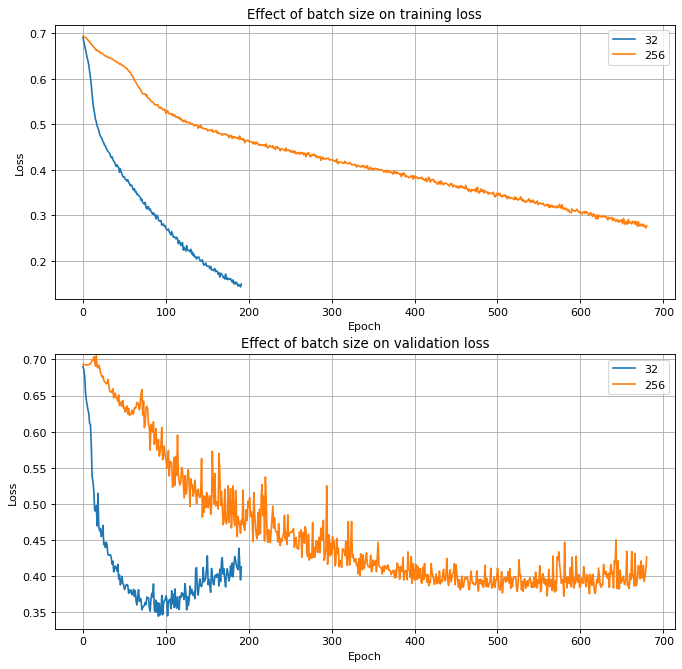

<Figure size 432x288 with 0 Axes>

In [14]:
ml_utils.plot_loss_by_param(model_state_by_batch_size_trial_2, 'batch size', 'batch_size_loss_trial_2')

In [54]:
print("Best training loss, batch size 32: {}".format(np.min(model_state_by_batch_size_trial_2[32].history['loss'])))
print("Best training loss, batch size 256: {}".format(np.min(model_state_by_batch_size_trial_2[256].history['loss'])))
print("Best validation loss, batch size 32: {}".format(np.min(model_state_by_batch_size_trial_2[32].history['val_loss'])))
print("Best validation loss, batch size 256: {}".format(np.min(model_state_by_batch_size_trial_2[256].history['val_loss'])))

Best training loss, batch size 32: 0.14301437291845656
Best training loss, batch size 256: 0.2727242395193714
Best validation loss, batch size 32: 0.3443534747786718
Best validation loss, batch size 256: 0.3722305235109831


We now observe that the small batch size outperforms the larger one. (Though, one could object by saying that the large batch size run didn't fully converge yet, seeing as it hasn't achieved the same training loss as the small one.)

Is it also true here that the large batch size finds weights close to initialization, and sharp minimizers? Let's first find the distance to the initial weights.

In [16]:
ml_utils.save_model_state(model_state_by_batch_size_trial_2, 'model_state_by_batch_size_trial_2')

In [4]:
initial_weights = ml_utils.build_model().get_weights()

batch_32_model = load_model('pickled_objects/batch_size_32_best_model_trial_2.h5')
batch_32_weights = batch_32_model.get_weights()

batch_256_model = load_model('pickled_objects/batch_size_256_best_model_trial_2.h5')
batch_256_weights = batch_256_model.get_weights()

In [18]:
for i in range(len(initial_weights)):
    print("Parameter set:", i)
    print("\tDistance from batch 32 to initial: ", np.linalg.norm(batch_32_weights[i] - initial_weights[i]))
    print("\tDistance from batch 256 to initial: ", np.linalg.norm(batch_256_weights[i] - initial_weights[i]))

Parameter set: 0
	Distance from batch 32 to initial:  5.254473
	Distance from batch 256 to initial:  4.2264876
Parameter set: 1
	Distance from batch 32 to initial:  0.49061885
	Distance from batch 256 to initial:  0.6367262
Parameter set: 2
	Distance from batch 32 to initial:  3.5041678
	Distance from batch 256 to initial:  3.290927
Parameter set: 3
	Distance from batch 32 to initial:  0.63949233
	Distance from batch 256 to initial:  0.44387928
Parameter set: 4
	Distance from batch 32 to initial:  3.8138456
	Distance from batch 256 to initial:  3.5175412
Parameter set: 5
	Distance from batch 32 to initial:  0.76752496
	Distance from batch 256 to initial:  0.38335085
Parameter set: 6
	Distance from batch 32 to initial:  4.816978
	Distance from batch 256 to initial:  3.710197
Parameter set: 7
	Distance from batch 32 to initial:  1.5094826
	Distance from batch 256 to initial:  0.8470867
Parameter set: 8
	Distance from batch 32 to initial:  6.7712054
	Distance from batch 256 to initial:  5

In [19]:
flattened_initial_weights = np.concatenate([x.flatten() for x in initial_weights])
flattened_32_weights = np.concatenate([x.flatten() for x in batch_32_weights])
flattened_256_weights = np.concatenate([x.flatten() for x in batch_256_weights])

In [20]:
print(
    "Distance from flattened batch 32 weights to initial weights: ",
    np.linalg.norm(flattened_32_weights - flattened_initial_weights)
)

Distance from flattened batch 32 weights to initial weights:  14.259794


In [21]:
print(
    "Distance from flattened batch 256 weights to initial weights: ",
    np.linalg.norm(flattened_256_weights - flattened_initial_weights)
)

Distance from flattened batch 256 weights to initial weights:  11.174291


We find that indeed, the larger batch size has weights that are closer to initialization. Now, can we measure how sharp the minimizer is?

In [22]:
alpha_values = np.linspace(-1, 2, 20)
training_losses = []
validation_losses = []
for alpha in alpha_values:
    print("\nTesting alpha: ", alpha)
    model = ml_utils.build_model()
    target_weights = [batch_256_weights[i]*alpha + batch_32_weights[i]*(1-alpha) for i in range(len(batch_32_weights))]
    model.set_weights(target_weights)
    training_loss, training_accuracy = model.evaluate(default_train)
    validation_loss, validation_accuracy = model.evaluate(default_validation)
    training_losses.append(training_loss)
    validation_losses.append(validation_loss)


Testing alpha:  -1.0
      5/Unknown - 7s 1s/step - loss: 2.3173 - accuracy: 0.6197
Testing alpha:  -0.8421052631578947
      5/Unknown - 1s 156ms/step - loss: 1.4928 - accuracy: 0.6539
Testing alpha:  -0.6842105263157895
      5/Unknown - 1s 149ms/step - loss: 0.9601 - accuracy: 0.7027
Testing alpha:  -0.5263157894736843
      5/Unknown - 1s 150ms/step - loss: 0.6306 - accuracy: 0.7635
Testing alpha:  -0.368421052631579
      5/Unknown - 1s 144ms/step - loss: 0.4506 - accuracy: 0.8126
Testing alpha:  -0.21052631578947367
      5/Unknown - 1s 147ms/step - loss: 0.3635 - accuracy: 0.8416
Testing alpha:  -0.052631578947368474
      5/Unknown - 1s 148ms/step - loss: 0.3401 - accuracy: 0.8446
Testing alpha:  0.10526315789473673
      5/Unknown - 1s 149ms/step - loss: 0.3579 - accuracy: 0.8368
Testing alpha:  0.26315789473684204
      5/Unknown - 1s 148ms/step - loss: 0.4055 - accuracy: 0.8143
Testing alpha:  0.42105263157894735
      5/Unknown - 1s 145ms/step - loss: 0.4602 - accuracy: 0.

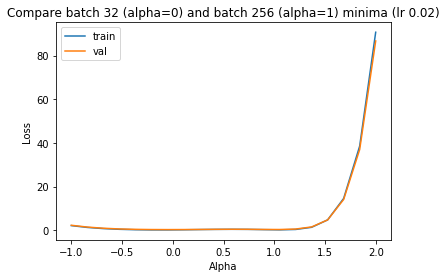

<Figure size 432x288 with 0 Axes>

In [26]:
plt.plot(alpha_values, training_losses, label='train')
plt.plot(alpha_values, validation_losses, label='val')
plt.title("Compare batch 32 (alpha=0) and batch 256 (alpha=1) minima (lr 0.02)")
plt.xlabel("Alpha")
plt.ylabel("Loss")
plt.legend()
plt.show()
plt.savefig('graphs/batch_size_alpha_trial_2')

In [5]:
batch_32_sharpness = ml_utils.get_sharpness(batch_32_model, default_train, epsilon=1e-3)
batch_256_sharpness = ml_utils.get_sharpness(batch_256_model, default_train, epsilon=1e-3)
print("\nBatch 32 sharpness: {:e}, batch 256 sharpness: {:e}".format(
    batch_32_sharpness,
    batch_256_sharpness,
))

     19/Unknown - 3s 141ms/step - loss: 0.8226 - accuracy: 0.7084
Batch 32 sharpness: 6.192267e+00, batch 256 sharpness: 4.661770e+01


In [5]:
batch_32_sharpness = ml_utils.get_sharpness(batch_32_model, default_train, epsilon=5e-3)
batch_256_sharpness = ml_utils.get_sharpness(batch_256_model, default_train, epsilon=5e-3)
print("\nBatch 32 sharpness: {:e}, batch 256 sharpness: {:e}".format(
    batch_32_sharpness,
    batch_256_sharpness,
))

     19/Unknown - 3s 138ms/step - loss: 17.9711 - accuracy: 0.5039
Batch 32 sharpness: 6.985595e+02, batch 256 sharpness: 1.426094e+03



x:  -1.0
      5/Unknown - 1s 144ms/step - loss: 0.8640 - accuracy: 0.6075
x:  -0.8947368421052632
      5/Unknown - 1s 142ms/step - loss: 0.7612 - accuracy: 0.6322
x:  -0.7894736842105263
      5/Unknown - 1s 151ms/step - loss: 0.6984 - accuracy: 0.6449
x:  -0.6842105263157895
      5/Unknown - 1s 145ms/step - loss: 0.6545 - accuracy: 0.6752
x:  -0.5789473684210527
      5/Unknown - 1s 148ms/step - loss: 0.6158 - accuracy: 0.6995
x:  -0.4736842105263158
      5/Unknown - 1s 142ms/step - loss: 0.5634 - accuracy: 0.7300
x:  -0.368421052631579
      5/Unknown - 1s 145ms/step - loss: 0.5009 - accuracy: 0.7672
x:  -0.26315789473684215
      5/Unknown - 1s 146ms/step - loss: 0.4366 - accuracy: 0.7990
x:  -0.1578947368421053
      5/Unknown - 1s 147ms/step - loss: 0.3801 - accuracy: 0.8285
x:  -0.052631578947368474
      5/Unknown - 1s 150ms/step - loss: 0.3465 - accuracy: 0.8414
x:  0.05263157894736836
      5/Unknown - 1s 152ms/step - loss: 0.3460 - accuracy: 0.8386
x:  0.1578947368421053

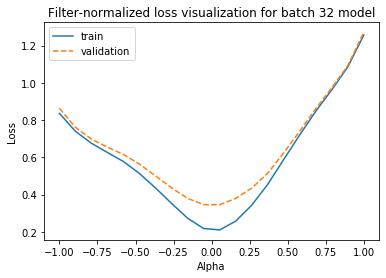

<Figure size 432x288 with 0 Axes>

In [39]:
x_values, batch_32_train_losses, batch_32_validation_losses = \
ml_utils.plot_loss_visualization_1d(
    batch_32_model,
    default_train,
    default_validation,
    title='Filter-normalized loss visualization for batch 32 model',
    output_filename='filter_normalized_visualization_1d_batch_32_model'
)


x:  -1.0
      5/Unknown - 1s 151ms/step - loss: 0.9885 - accuracy: 0.5808
x:  -0.8947368421052632
      5/Unknown - 1s 144ms/step - loss: 0.9328 - accuracy: 0.595 - 1s 145ms/step - loss: 0.9328 - accuracy: 0.5950
x:  -0.7894736842105263
      5/Unknown - 1s 148ms/step - loss: 0.9075 - accuracy: 0.6096
x:  -0.6842105263157895
      5/Unknown - 1s 148ms/step - loss: 0.8751 - accuracy: 0.6328
x:  -0.5789473684210527
      5/Unknown - 1s 148ms/step - loss: 0.8255 - accuracy: 0.6531
x:  -0.4736842105263158
      5/Unknown - 1s 153ms/step - loss: 0.7554 - accuracy: 0.6739
x:  -0.368421052631579
      5/Unknown - 1s 149ms/step - loss: 0.6701 - accuracy: 0.6986
x:  -0.26315789473684215
      5/Unknown - 1s 152ms/step - loss: 0.5724 - accuracy: 0.7356
x:  -0.1578947368421053
      5/Unknown - 1s 150ms/step - loss: 0.4619 - accuracy: 0.7891
x:  -0.052631578947368474
      5/Unknown - 1s 148ms/step - loss: 0.3828 - accuracy: 0.8276
x:  0.05263157894736836
      5/Unknown - 1s 145ms/step - loss:

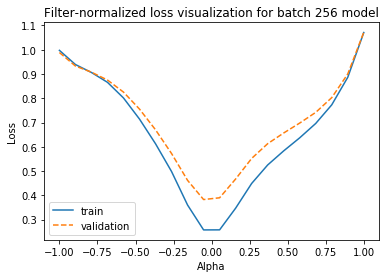

<Figure size 432x288 with 0 Axes>

In [48]:
x_values, batch_256_train_losses, batch_256_validation_losses = \
ml_utils.plot_loss_visualization_1d(
    batch_256_model,
    default_train,
    default_validation,
    title='Filter-normalized loss visualization for batch 256 model',
    output_filename='filter_normalized_visualization_1d_batch_256_model'
)

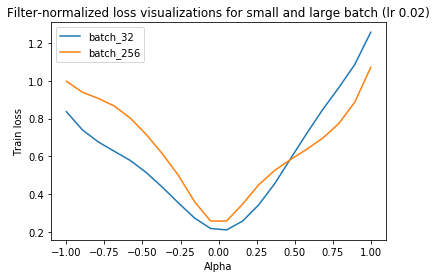

In [49]:
plt.plot(x_values, batch_32_train_losses, label='batch_32')
plt.plot(x_values, batch_256_train_losses, label='batch_256')
plt.ylabel('Train loss')
plt.xlabel('Alpha')
plt.title('Filter-normalized loss visualizations for small and large batch (lr 0.02)')
plt.legend()
plt.savefig('graphs/filter_normalized_loss_1d_for_small_and_large_batch_lr_2e-2')


 x: -1.0, y: -1.0
     19/Unknown - 3s 148ms/step - loss: 7.5908 - accuracy: 0.4969
 x: -0.5, y: -1.0
     19/Unknown - 3s 145ms/step - loss: 1.9742 - accuracy: 0.4998
 x: 0.0, y: -1.0
     19/Unknown - 3s 142ms/step - loss: 1.3800 - accuracy: 0.5302
 x: 0.5, y: -1.0
     19/Unknown - 3s 144ms/step - loss: 2.0619 - accuracy: 0.5513
 x: 1.0, y: -1.0
     19/Unknown - 3s 147ms/step - loss: 3.5506 - accuracy: 0.5797
 x: -1.0, y: -0.5
     19/Unknown - 3s 143ms/step - loss: 2.3940 - accuracy: 0.5004
 x: -0.5, y: -0.5
     19/Unknown - 3s 146ms/step - loss: 0.7461 - accuracy: 0.5325
 x: 0.0, y: -0.5
     19/Unknown - 3s 141ms/step - loss: 0.6506 - accuracy: 0.6588
 x: 0.5, y: -0.5
     19/Unknown - 3s 140ms/step - loss: 1.0356 - accuracy: 0.6452
 x: 1.0, y: -0.5
     19/Unknown - 3s 143ms/step - loss: 1.2517 - accuracy: 0.6491
 x: -1.0, y: 0.0
     19/Unknown - 3s 139ms/step - loss: 1.0584 - accuracy: 0.5458
 x: -0.5, y: 0.0
     19/Unknown - 3s 140ms/step - loss: 0.6745 - accuracy: 0.6021

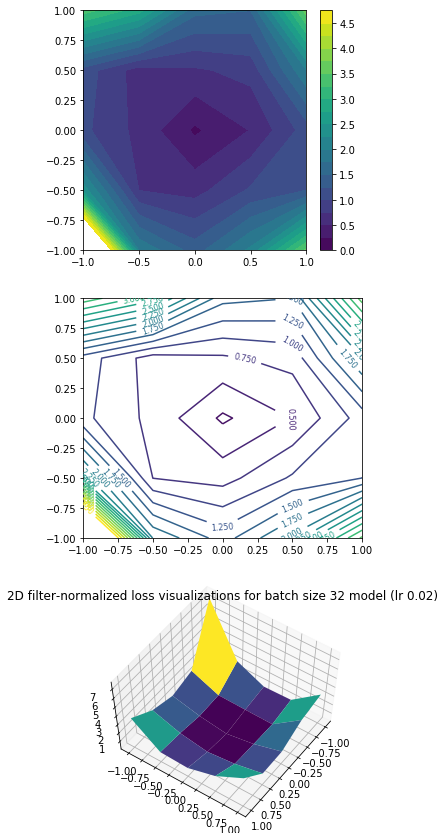

<Figure size 432x288 with 0 Axes>

In [55]:
X, Y, Z = ml_utils.plot_loss_visualization_2d(
    batch_32_model,
    default_train,
    mode='all',
    title='2D filter-normalized loss visualizations for batch size 32 model (lr 0.02)',
    output_filename='filter_normalized_loss_2d_for_batch_32_lr_2e-2',
)


 x: -1.0, y: -1.0
     19/Unknown - 3s 143ms/step - loss: 5.9755 - accuracy: 0.5122
 x: -0.5, y: -1.0
     19/Unknown - 3s 141ms/step - loss: 2.5022 - accuracy: 0.5710
 x: 0.0, y: -1.0
     19/Unknown - 3s 139ms/step - loss: 2.8149 - accuracy: 0.5625
 x: 0.5, y: -1.0
     19/Unknown - 3s 136ms/step - loss: 3.0028 - accuracy: 0.5339
 x: 1.0, y: -1.0
     19/Unknown - 3s 137ms/step - loss: 4.0798 - accuracy: 0.4800
 x: -1.0, y: -0.5
     19/Unknown - 3s 138ms/step - loss: 2.1312 - accuracy: 0.5450
 x: -0.5, y: -0.5
     19/Unknown - 3s 136ms/step - loss: 0.8935 - accuracy: 0.6153
 x: 0.0, y: -0.5
     19/Unknown - 3s 136ms/step - loss: 0.8082 - accuracy: 0.6056
 x: 0.5, y: -0.5
     19/Unknown - 3s 140ms/step - loss: 0.8236 - accuracy: 0.5985
 x: 1.0, y: -0.5
     19/Unknown - 3s 136ms/step - loss: 1.0558 - accuracy: 0.5483
 x: -1.0, y: 0.0
     19/Unknown - 3s 137ms/step - loss: 2.5995 - accuracy: 0.5439
 x: -0.5, y: 0.0
     19/Unknown - 3s 138ms/step - loss: 0.8023 - accuracy: 0.6458

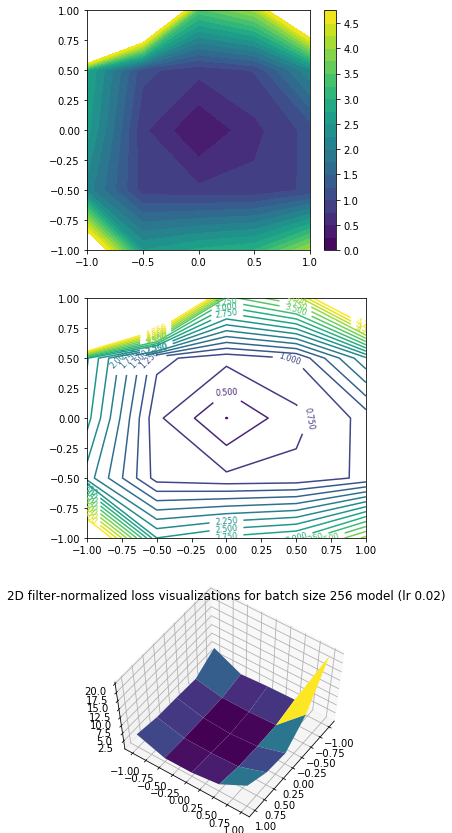

<Figure size 432x288 with 0 Axes>

In [56]:
X, Y, Z = ml_utils.plot_loss_visualization_2d(
    batch_256_model,
    default_train,
    mode='all',
    title='2D filter-normalized loss visualizations for batch size 256 model (lr 0.02)',
    output_filename='filter_normalized_loss_2d_for_batch_256_lr_2e-2',
)

We find that the large batch size still finds a solution closer to the initial weights, and that its minimizer is sharper than that of the small batch size.

**Conclusion so far**: Performance on batch size is sensitive to the learning rate. Lower learning rates are better for smaller batch sizes. Also, large batch sizes a) find solutions closer to the initial weights b) find sharp minimizers.

In [80]:
from sklearn.manifold import TSNE

weights_across_epochs = []
for epoch, weights in model_state_by_batch_size_trial_1[32].weights_by_epoch.items():
    weights_across_epochs.append(weights[-2].flatten())
tsne = TSNE(n_components=2, verbose=1)
transformed_weights = tsne.fit_transform(weights_across_epochs)

[t-SNE] Computing 29 nearest neighbors...
[t-SNE] Indexed 30 samples in 0.000s...
[t-SNE] Computed neighbors for 30 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 30 / 30
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 43.379154
[t-SNE] KL divergence after 1000 iterations: 0.501490


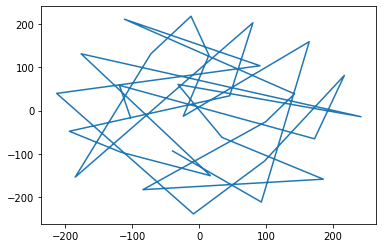

In [81]:
plt.plot(transformed_weights[:,0], transformed_weights[:,1])
plt.show()

In [3]:
batch_sizes = [32, 128, 512]
model_state_by_batch_size_trial_1 = {}

for batch_size in batch_sizes:
    # Read training data
    train, validation = ml_utils.load_batched_and_resized_dataset(
        dataset_name='cats_and_dogs',   
        batch_size=batch_size,
        img_size=128
    )

    # Build and train model
    model = ml_utils.build_model()
    es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)
    mc = ModelCheckpoint(
        'pickled_objects/batch_size_{}_trial_1_weights.h5'.format(batch_size),
        monitor='val_loss',
        mode='min',
        verbose=1,
        save_best_only=True,
        save_weights_only=True
    )
    model_state_by_batch_size_trial_1[batch_size] = ml_utils.train_model(
        model,
        train,
        validation,
        epochs=1500,
        extra_callbacks=[es, mc],
    )

Training Data Summary
No. of examples: 18610
Class: 0 :::: Count: 9378 :::: Percentage: 50.39226222461043
Class: 1 :::: Count: 9232 :::: Percentage: 49.60773777538957

Validation Data Summary
No. of examples: 4652
Class: 0 :::: Count: 2280 :::: Percentage: 49.011177987962164
Class: 1 :::: Count: 2372 :::: Percentage: 50.988822012037836
Epoch 1/1500
    582/Unknown - 27s 46ms/step - loss: 0.6860 - accuracy: 0.5435
Saving weights for epoch 0
582/582 [==============================] - 33s 57ms/step - loss: 0.6860 - accuracy: 0.5435 - val_loss: 0.6627 - val_accuracy: 0.6279
Epoch 2/1500
582/582 [==============================] - 12s 21ms/step - loss: 0.6911 - accuracy: 0.5155 - val_loss: 0.6928 - val_accuracy: 0.5099
Epoch 3/1500
582/582 [==============================] - 12s 21ms/step - loss: 0.6900 - accuracy: 0.5264 - val_loss: 0.6677 - val_accuracy: 0.6131
Epoch 4/1500
582/582 [==============================] - 12s 21ms/step - loss: 0.6494 - accuracy: 0.6271 - val_loss: 0.6357 - val_ac

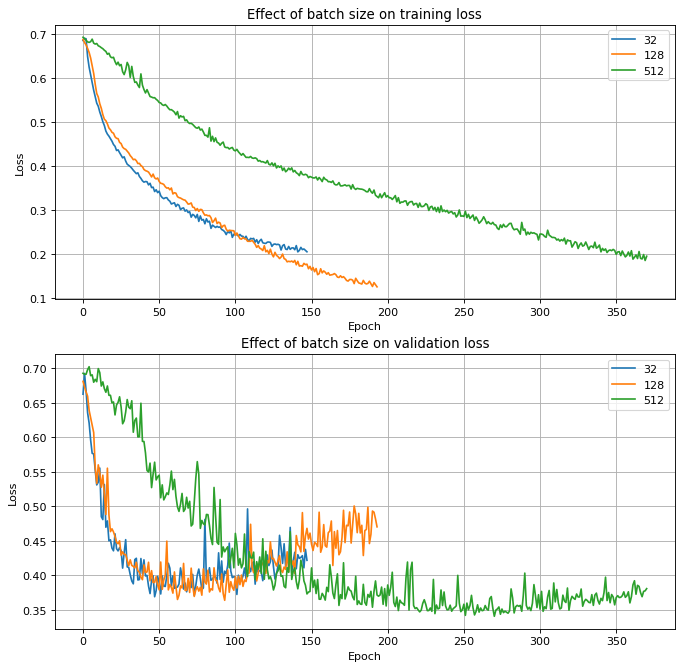

<Figure size 432x288 with 0 Axes>

In [4]:
ml_utils.plot_loss_by_param(model_state_by_batch_size_trial_1, 'batch size', 'batch_size_loss_trial_1')

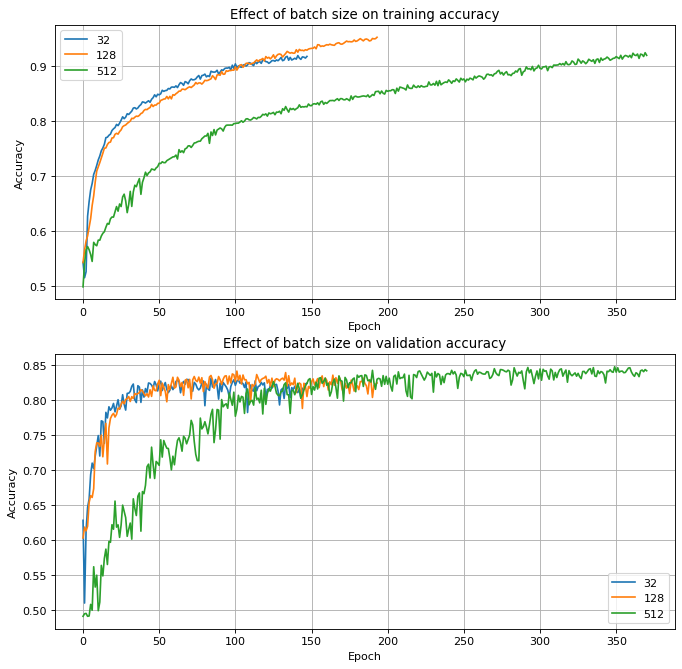

<Figure size 432x288 with 0 Axes>

In [6]:
ml_utils.plot_accuracies_by_param(model_state_by_batch_size_trial_1, 'batch size', 'batch_size_accuracy_trial_1')

In [8]:
ml_utils.save_model_state(model_state_by_batch_size_trial_1, 'model_state_by_batch_size_trial_1')

Surprisingly, batch sizes 32 and 128 performed worse than 512. Could this be because the learning rate is too high? Let's try a lower learning rate of 0.01.

In [10]:
batch_sizes = [32, 128, 512]
model_state_by_batch_size_trial_2 = {}

for batch_size in batch_sizes:
    # Read training data
    train, validation = ml_utils.load_batched_and_resized_dataset(
        dataset_name='cats_and_dogs',   
        batch_size=batch_size,
        img_size=128
    )

    # Build and train model
    model = ml_utils.build_model(optimizer=keras.optimizers.SGD(learning_rate=0.01))
    es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)
    model_state_by_batch_size_trial_2[batch_size] = ml_utils.train_model(
        model,
        train,
        validation,
        epochs=10000,
        extra_callbacks=[es],
    )

Training Data Summary
No. of examples: 18610
Class: 0 :::: Count: 9378 :::: Percentage: 50.39226222461043
Class: 1 :::: Count: 9232 :::: Percentage: 49.60773777538957

Validation Data Summary
No. of examples: 4652
Class: 0 :::: Count: 2280 :::: Percentage: 49.011177987962164
Class: 1 :::: Count: 2372 :::: Percentage: 50.988822012037836
Epoch 1/10000
    582/Unknown - 25s 43ms/step - loss: 0.6926 - accuracy: 0.5135
Saving weights for epoch 0
582/582 [==============================] - 31s 54ms/step - loss: 0.6926 - accuracy: 0.5135 - val_loss: 0.6919 - val_accuracy: 0.4963
Epoch 2/10000
582/582 [==============================] - 12s 21ms/step - loss: 0.6869 - accuracy: 0.5651 - val_loss: 0.6902 - val_accuracy: 0.5045
Epoch 3/10000
582/582 [==============================] - 12s 21ms/step - loss: 0.6785 - accuracy: 0.5801 - val_loss: 0.6920 - val_accuracy: 0.5103
Epoch 4/10000
582/582 [==============================] - 12s 21ms/step - loss: 0.6716 - accuracy: 0.5861 - val_loss: 0.6793 - va

KeyboardInterrupt: 

Since batch size 8 performed poorly, the learning rate may be too high for small batch sizes. On the other hand, 32 and 128 didn't converge, so we may need to up the number of epochs. So, let's try a lower learning rate and more epochs.

In [10]:
batch_sizes = [8, 32, 128, 512, 2048]
model_state_by_type_trial_2 = {}

for batch_size in batch_sizes:
    # Read training data
    train, validation = ml_utils.load_batched_and_resized_dataset(
        dataset_name='cats_and_dogs',   
        batch_size=batch_size,
        img_size=128
    )

    # Build and train model
    model = ml_utils.build_model(optimizer=keras.optimizers.SGD(learning_rate=0.05))
    model_state_by_type_trial_2[batch_size] = ml_utils.train_model(model, train, validation, epochs=100)

Training Data Summary
No. of examples: 18610
Class: 0 :::: Count: 9378 :::: Percentage: 50.39226222461043
Class: 1 :::: Count: 9232 :::: Percentage: 49.60773777538957

Validation Data Summary
No. of examples: 4652
Class: 0 :::: Count: 2280 :::: Percentage: 49.011177987962164
Class: 1 :::: Count: 2372 :::: Percentage: 50.988822012037836
Epoch 1/100
2327/2327 [==============================] - 55s 24ms/step - loss: 0.6840 - accuracy: 0.5558 - val_loss: 0.6565 - val_accuracy: 0.6187
Epoch 2/100
2327/2327 [==============================] - 28s 12ms/step - loss: 0.6485 - accuracy: 0.6257 - val_loss: 0.6115 - val_accuracy: 0.6829
Epoch 3/100
2327/2327 [==============================] - 27s 12ms/step - loss: 0.6004 - accuracy: 0.6779 - val_loss: 0.5513 - val_accuracy: 0.7291
Epoch 4/100
2327/2327 [==============================] - 27s 12ms/step - loss: 0.5560 - accuracy: 0.7195 - val_loss: 0.5134 - val_accuracy: 0.7517
Epoch 5/100
2327/2327 [==============================] - 27s 12ms/step - l

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2327/2327 [==============================] - 27s 12ms/step - loss: 0.4089 - accuracy: 0.8139 - val_loss: 0.4056 - val_accuracy: 0.8123
Epoch 78/100
2327/2327 [==============================] - 27s 12ms/step - loss: 0.4135 - accuracy: 0.8120 - val_loss: 0.4086 - val_accuracy: 0.8113
Epoch 79/100
2327/2327 [==============================] - 27s 12ms/step - loss: 0.4138 - accuracy: 0.8142 - val_loss: 0.4367 - val_accuracy: 0.7904
Epoch 80/100
2327/2327 [==============================] - 27s 12ms/step - loss: 0.4150 - accuracy: 0.8098 - val_loss: 0.4156 - val_accuracy: 0.8087
Epoch 81/100
2327/2327 [==============================] - 27s 12ms/step - loss: 0.4067 - accuracy: 0.8132 - val_loss: 0.3997 - val_accuracy: 0.8199
Epoch 82/100
2327/2327 [==============================] - 28s 12ms/step - loss: 0.4170 - accuracy: 0.8093 - val_loss: 0.4154 - val_accuracy: 0.8091
Epoch 83/100
2327/2327 [==============================] - 27s 12ms/step - loss: 0.4151 - accuracy: 0.8108 - val_loss: 0.4222 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2327/2327 [==============================] - 27s 12ms/step - loss: 0.4341 - accuracy: 0.8047 - val_loss: 0.4436 - val_accuracy: 0.7954
Epoch 90/100
2327/2327 [==============================] - 27s 12ms/step - loss: 0.4243 - accuracy: 0.8070 - val_loss: 0.4081 - val_accuracy: 0.8113
Epoch 91/100
2327/2327 [==============================] - 27s 12ms/step - loss: 0.4140 - accuracy: 0.8110 - val_loss: 0.4288 - val_accuracy: 0.8076
Epoch 92/100
2327/2327 [==============================] - 27s 12ms/step - loss: 0.4260 - accuracy: 0.8085 - val_loss: 0.4102 - val_accuracy: 0.8205
Epoch 93/100
2327/2327 [==============================] - 27s 12ms/step - loss: 0.4138 - accuracy: 0.8118 - val_loss: 0.4240 - val_accuracy: 0.8134
Epoch 94/100
2327/2327 [==============================] - 27s 12ms/step - loss: 0.4352 - accuracy: 0.7985 - val_loss: 0.4065 - val_accuracy: 0.8147
Epoch 95/100
2327/2327 [==============================] - 28s 12ms/step - loss: 0.4286 - accuracy: 0.8045 - val_loss: 0.4016 

KeyboardInterrupt: 

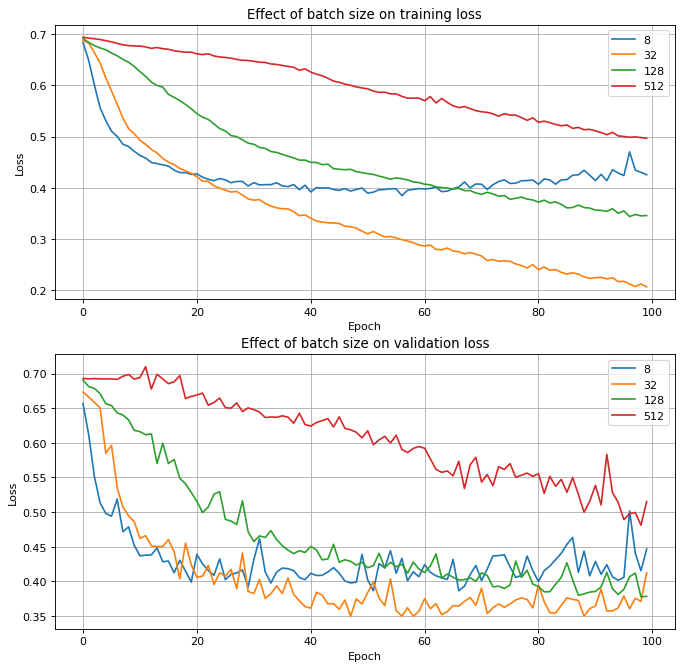

<Figure size 432x288 with 0 Axes>

In [11]:
ml_utils.plot_loss_by_param(model_state_by_type, 'batch size', 'batch_size_loss_2nd_try')

In [13]:
ml_utils.save_model_state(model_state_by_type, 'model_state_by_batch_size_2nd_try')

It looks like it may take many more iterations for larger batch sizes to converge. Let's try early stopping so we don't have to manually specify the number of iterations to run.

In [3]:
batch_sizes = [8, 32, 128, 512]
model_state_by_type_trial_3 = {}

for batch_size in batch_sizes:
    # Read training data
    train, validation = ml_utils.load_batched_and_resized_dataset(
        dataset_name='cats_and_dogs',   
        batch_size=batch_size,
        img_size=128
    )

    # Build and train model
    model = ml_utils.build_model(optimizer=keras.optimizers.SGD(learning_rate=0.01))
    es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)
    model_state_by_type_trial_3[batch_size] = ml_utils.train_model(
        model,
        train,
        validation,
        epochs=20000,
        extra_callbacks=[es]
    )

Training Data Summary
No. of examples: 18610
Class: 0 :::: Count: 9378 :::: Percentage: 50.39226222461043
Class: 1 :::: Count: 9232 :::: Percentage: 49.60773777538957

Validation Data Summary
No. of examples: 4652
Class: 0 :::: Count: 2280 :::: Percentage: 49.011177987962164
Class: 1 :::: Count: 2372 :::: Percentage: 50.988822012037836
Epoch 1/20000
2327/2327 [==============================] - 57s 25ms/step - loss: 0.6873 - accuracy: 0.5503 - val_loss: 0.6778 - val_accuracy: 0.5929
Epoch 2/20000
2327/2327 [==============================] - 27s 12ms/step - loss: 0.6740 - accuracy: 0.5848 - val_loss: 0.6626 - val_accuracy: 0.6193
Epoch 3/20000
2327/2327 [==============================] - 27s 12ms/step - loss: 0.6580 - accuracy: 0.6114 - val_loss: 0.6377 - val_accuracy: 0.6599
Epoch 4/20000
2327/2327 [==============================] - 27s 12ms/step - loss: 0.6353 - accuracy: 0.6403 - val_loss: 0.6135 - val_accuracy: 0.6750
Epoch 5/20000
2327/2327 [==============================] - 27s 12m

2327/2327 [==============================] - 27s 11ms/step - loss: 0.4727 - accuracy: 0.7692


KeyboardInterrupt: 

In [45]:
for batch_size, model_state in model_state_by_type.items():
    print("Batch size {}".format(batch_size))
    for i in range(4):
        print("\tEpoch {}".format(i))
        flattened_weights = np.array([])
        curr_weights = model_state.weights_by_epoch[i]
        for j in range(len(curr_weights)):
            flattened_weights = np.concatenate((flattened_weights, curr_weights[j].flatten()))
        print("\tNorm: ", np.linalg.norm(flattened_weights))

Epoch 0
Norm:  27.4336502727029
Epoch 1
Norm:  27.449913808055737
Epoch 2
Norm:  27.466143766527928
Epoch 3
Norm:  27.4870729318222
